In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 7.0)

import folium
import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
from branca.element import Figure
from folium.plugins import HeatMapWithTime
from pandas.plotting import parallel_coordinates
from sklearn.preprocessing import StandardScaler

In [2]:
def read_df(date):
    df = pd.read_csv("../data/" + date + "_all.csv", index_col = 0, parse_dates = ["dateTime"])
    df = df.set_index(df.dateTime.apply(lambda x: x.time()))
    return df
    
def del_outliers(df, col, mark = 0, above = False, below = False):
    original_idx = df.index
    df = df.reset_index(drop = True).copy()
    
    q3 = df[col].quantile(0.75)
    q1 = df[col].quantile(0.25)
    iqr = q3 - q1
    ul = q3 + 1.5 * iqr
    ll =  q1 - 1.5 * iqr
    idx = []
    if not mark:
        # outlier deletion method choose
        if above:
            idx.extend(df[df[col] >= ul].index.tolist())
        if below:
            idx.extend(df[df[col] <= ll].index.tolist())
        if (above!=True and below!=True):
            idx.extend(df[df[col] >= 500].index.tolist())
        # adjust index and other stuff
        sub = df.drop(idx, axis = 0)
        sub = sub.set_index(sub.dateTime.apply(lambda x: x.time()))
        dropped = df.loc[idx, :]
    else:
        # mark nans
        if mark == 1:
            idx.extend(df[(df[col] >= ul) | (df[col] <= ll)].index.tolist())
        elif mark ==2:
            idx.extend(df[df[col] >= 500].index.tolist())
        df.loc[idx, col] = np.nan
        # adjust for index and other stuff
        sub = df
        sub = sub.set_index(original_idx)
        dropped = df.loc[idx, :]

    print("Marked/Deleted rows:", len(idx))
    return sub, dropped

def read_preprocess(df_date):
    df = read_df(df_date)
    sub, _ = del_outliers(df, "pm10", mark = 2)
    sub, _ = del_outliers(sub, "pm2_5", mark = 2)
    sub, _ = del_outliers(sub, "pm1_0", mark = 2)

    # creating some useful columns
    sub["minute"] = sub.dateTime.apply(lambda x: x.minute)
    sub["hour"] = sub.dateTime.apply(lambda x: x.hour)
    sub["time_appx"] = sub.hour*60 + sub.minute
    sub["pol_class"] = sub.pm10.apply(lambda x: pol_map2class(x))

    sub = sub.drop(["dateTime"], axis =1)
    sub = sub[(sub.lat >=0) & (sub.long >=0)]
    return df, sub

def line_plots(df, cols):
    for col in cols:
        plt.figure(figsize=(7,4))
        df[col].plot()
        plt.title(col)
        
def box_plots(df, cols):
    for col in cols:
        plt.figure(figsize=(7,4))
        sns.boxplot(df[col], orient ="v")    
        plt.title(col)
        
def dist_plots(df, cols):
    for col in cols:
        plt.figure(figsize=(7,4))
        sns.distplot(df[col], kde = True)    

def pol_map2class(x):
    if (x>=0) and (x<=50):
        mapped_class = "good"
    elif (x>50) and (x<=100):
        mapped_class = "moderate"
    elif (x>100) and (x<=150):
        mapped_class = "partially unhealthy"
    elif (x>150) and (x<=200):
        mapped_class = "unhealthy"
    elif (x>200) and (x<=300):
        mapped_class = "very unhealthy"
    else:
        mapped_class = "hazardous"
    return mapped_class

def to_time(time_string):
    return pd.to_datetime(time_string).time()

In [3]:
using_all = False
df_date = "2020-10-20"
palette = {"good":"yellow", "moderate":"green", "partially unhealthy":"orange", "unhealthy":"pink", "very unhealthy":"red",\
           "hazardous":"black"}

In [4]:
if using_all:
    for i in range(11, 21):
        temp_date = "2020-10-" + str(i)
        temp_df, temp_sub = read_preprocess(temp_date)
        if i==11:
            df, sub = temp_df, temp_sub
        else:
            df = pd.concat([df, temp_df], axis = 0)
            sub = pd.concat([sub, temp_sub], axis =0)
        print("---")
else:    
    pol_cols = ["pm1_0", "pm2_5", "pm10"]
    df, sub = read_preprocess(df_date)

Marked/Deleted rows: 379
Marked/Deleted rows: 274
Marked/Deleted rows: 134


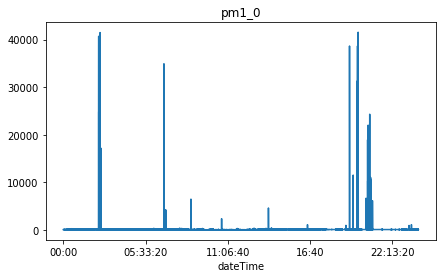

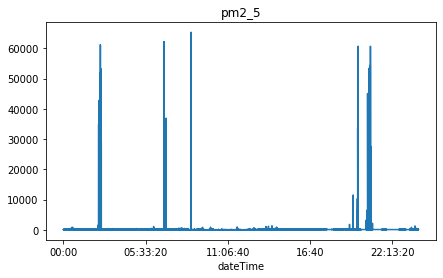

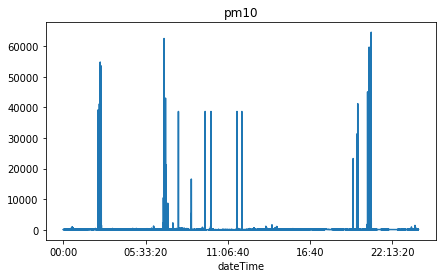

In [15]:
line_plots(df, pol_cols)

After removal of outliers


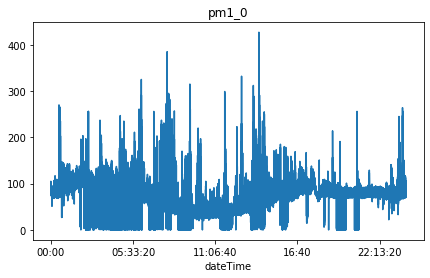

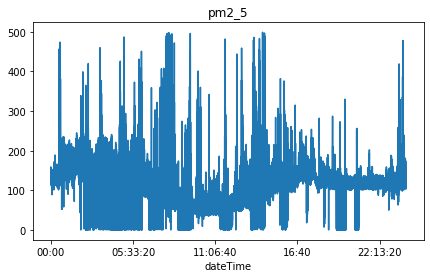

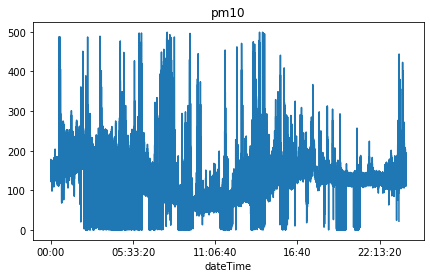

In [16]:
print("After removal of outliers")
line_plots(sub, pol_cols)

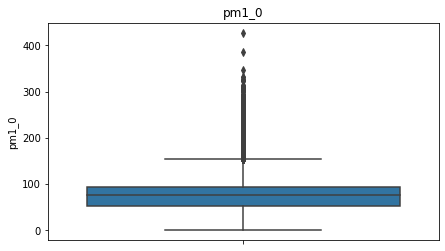

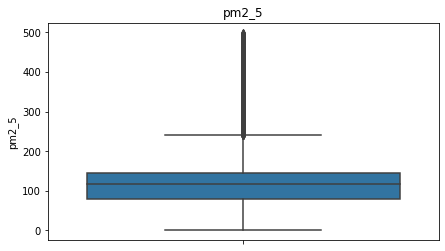

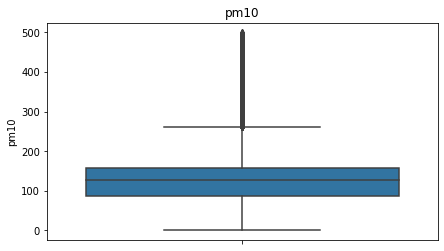

In [17]:
box_plots(sub, pol_cols)

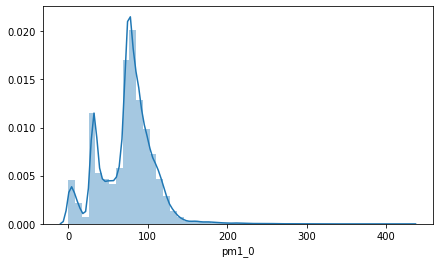

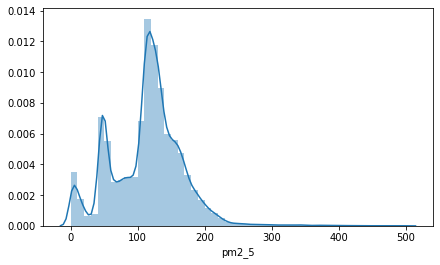

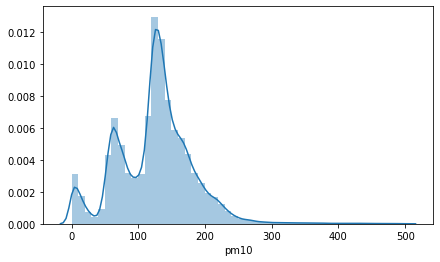

In [18]:
dist_plots(sub, pol_cols)

In [19]:
sub[pol_cols].corr()

pm1_0     pm2_5      pm10
pm1_0  1.000000  0.985051  0.973423
pm2_5  0.985051  1.000000  0.991657
pm10   0.973423  0.991657  1.000000

The original plots have really high values. Really strong outliers. These are clearly not possible and thus can be marked as NANs using one of two implemented schemes. 

**The Outlier-handled plots when plotted together are extremely noisy and vary a lot.** This is probably because of the multiple buses that are moving in the city covering different places. **We also see a lot of 0 PM values (eg: between 00:00 and 05:30).** This is a potential concern and will be dealt with. We also see that the correlation is very high among the three so from now on, we will use, more or less, pm10 for our EDA.

We have right-skewed multimodal distributions. This "might" help in choosing the procedure we choose later. **Also, finding out what the mode actually depends on might help in understanding why the distributions have peaks followed by pits.** 

In [5]:
sub = sub.drop(["pm1_0", "pm2_5"], axis = 1)
sub= sub.rename(columns={"pm10":"pm"})

### 1. Where are low Pol values coming from ? 

The below is one section of low pol values

Text(0, 0.5, 'Pm values')

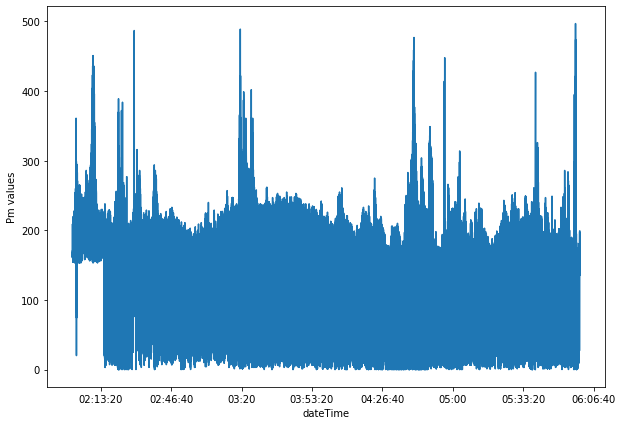

In [9]:
if using_all:
    time_sub = sub.iloc[:350000, :].copy() # when using all dfs
else:
    time_sub = sub.loc[to_time("02:00:00"):to_time("06:00:00"), :].copy()
time_sub.pm.plot()
plt.ylabel("Pm values")

We see for different devices if some device is malfunctioning

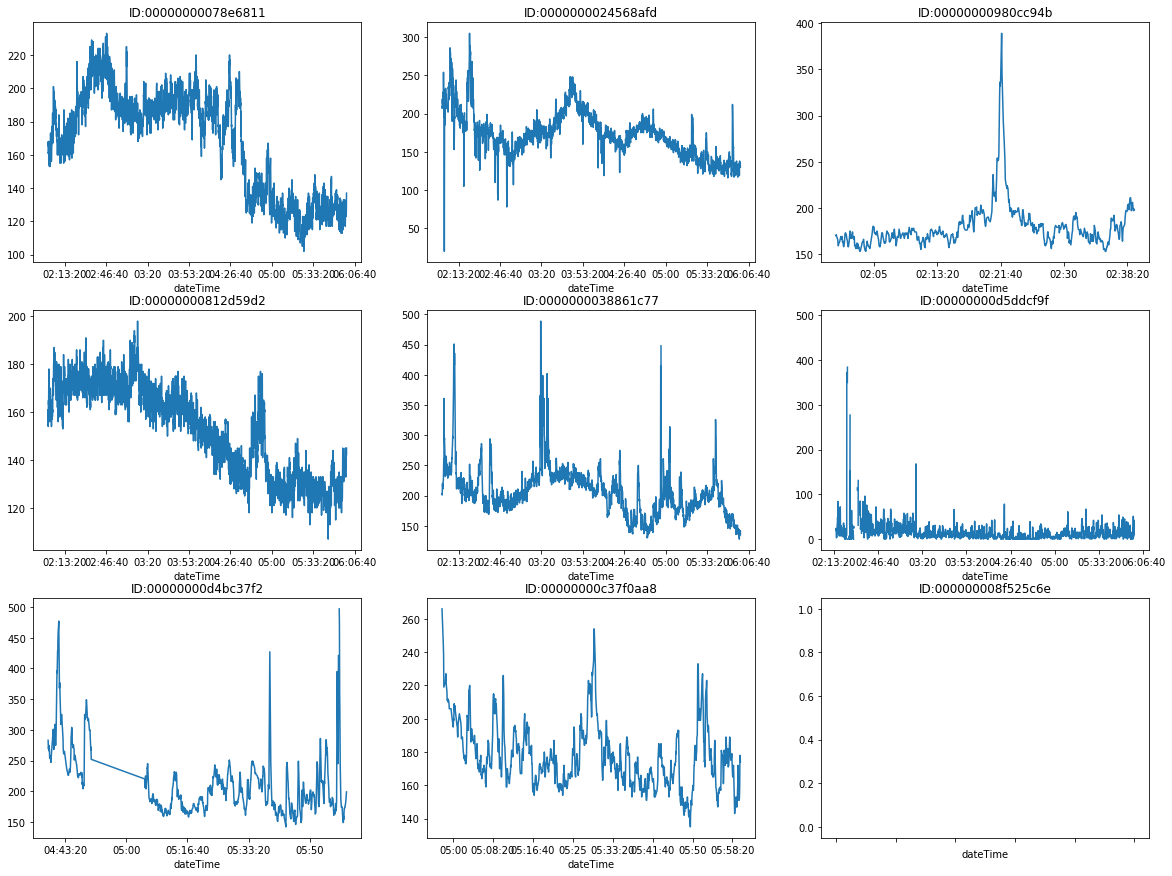

In [10]:
deviceIds = sub.deviceId.unique()
fig, ax= plt.subplots(3,3, figsize = (20, 15))
for i in range(3):
    for j in range(3):
        time_sub.pm[time_sub.deviceId == deviceIds[i*3+j]].plot(ax = ax[i][j])
        ax[i][j].set_title("ID:" + deviceIds[i*3+j])

It can be clearly seen that while all of the devices are emitting the results properly, the 6th device seems to be emitting a lot of 0 values. We will get to know if it's a defect or not by doing the following: 
<b>
1. What are the pollution levels at the regions it has been positioned in ?
2. Check through other datasets to confirm if it's behaviour is the same or not.
3. Does it's beahviour change throughout the day ? Or does it depend on time or some other other factor ?
</b>

As for the above 3rd point, these are the values throughout the day 

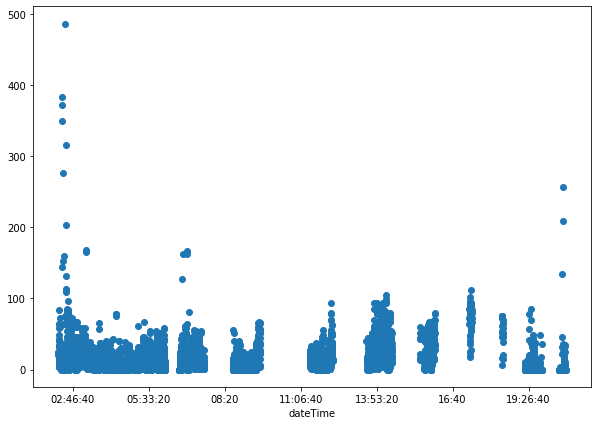

In [11]:
if using_all:
    bad_id = deviceIds[6] # when using all dfs
else:
    bad_id = deviceIds[5]
bad_df = sub[sub.deviceId == bad_id]
bad_df.pm.plot(style = "s", marker= "o")

The sensor emits too many low values. Maybe this is because of the location it is positioned at as it might happen that the pol values are less there. 

Text(0.5, 0.98, 'All locations of given bus')

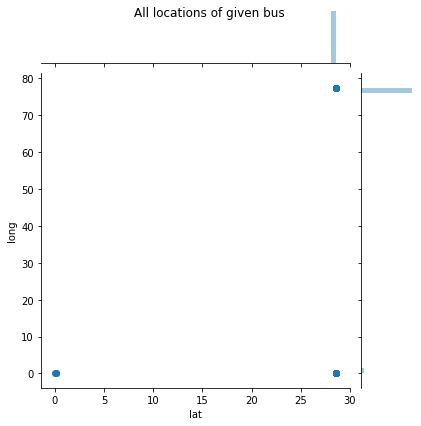

In [12]:
f = sns.jointplot(bad_df.lat, bad_df.long)
f.fig.suptitle("All locations of given bus")

We see another problem in the data. **0 valued lat and long values**. To recitfy, we could either interpolate according to the trajectory in a trip or just drop them altogether. For now, we drop them.

Text(0.5, 1.0, 'Actual Path Travelled')

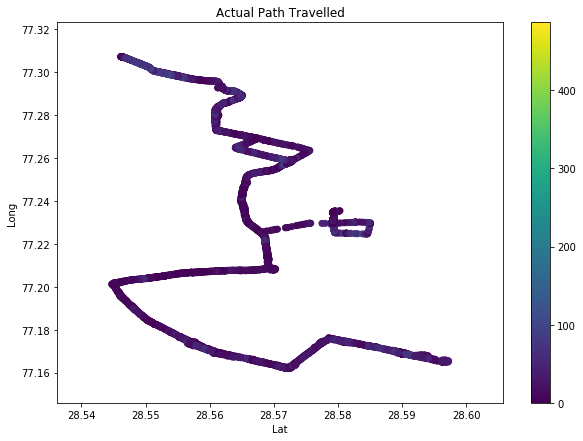

In [13]:
bad_df = bad_df[(bad_df.lat !=0) & (bad_df.long != 0)]
f = plt.scatter(bad_df.lat, bad_df.long, c = bad_df.pm)
plt.colorbar()
plt.xlabel("Lat")
plt.ylabel("Long")
plt.title("Actual Path Travelled")

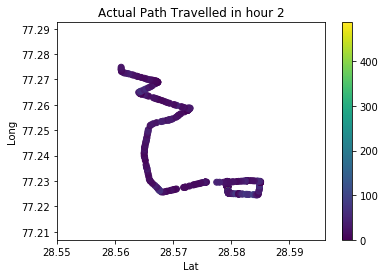

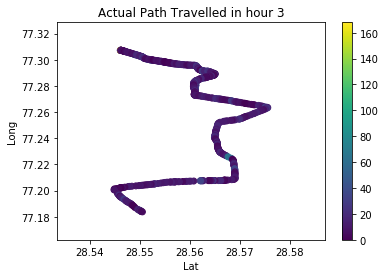

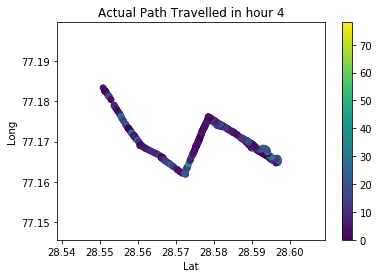

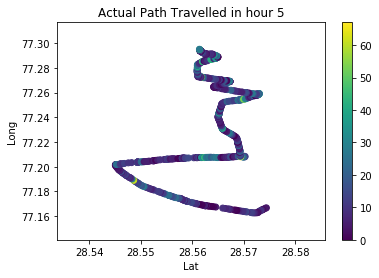

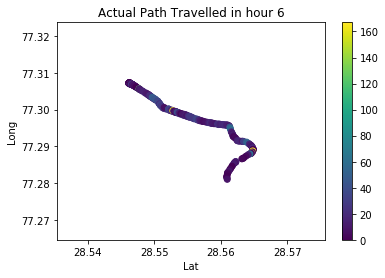

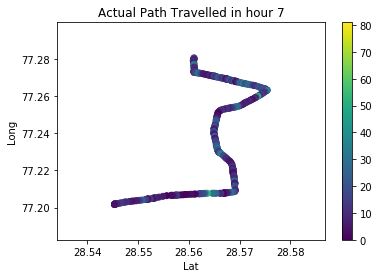

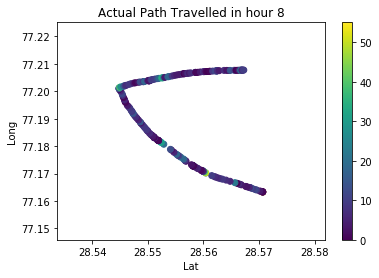

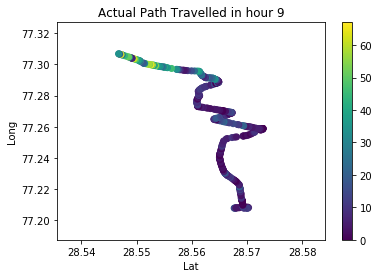

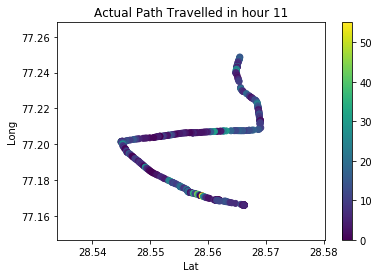

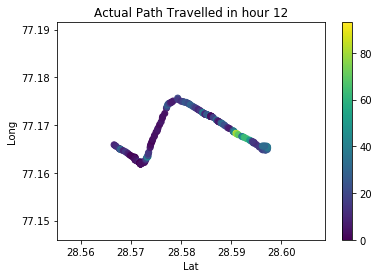

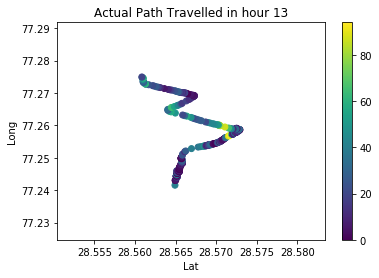

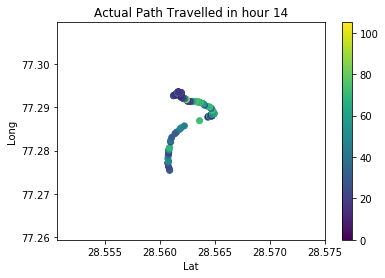

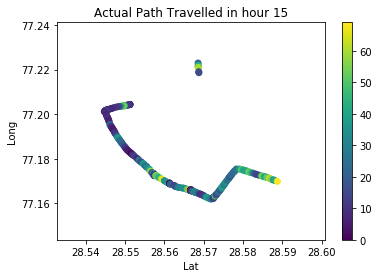

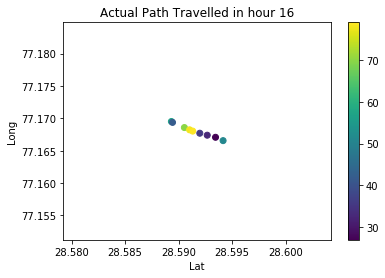

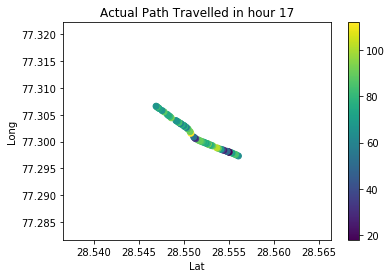

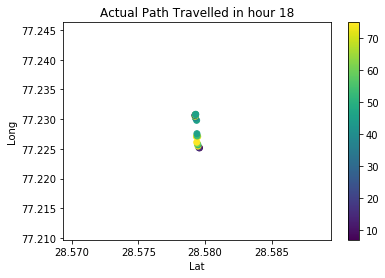

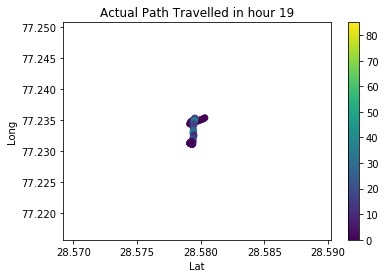

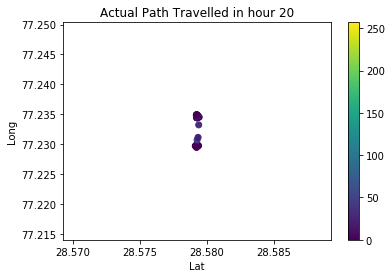

In [14]:
for h in bad_df.hour.unique():
    plt.figure(figsize = (6,4))
    f = plt.scatter(bad_df[bad_df.hour == h].lat, bad_df[bad_df.hour == h].long, c = bad_df[bad_df.hour == h].pm)
    plt.colorbar()
    plt.xlabel("Lat")
    plt.ylabel("Long")
    plt.title("Actual Path Travelled in hour " + str(h))

So no, it's behaviour is roughly the same throughout the day. Overall, a lot of low values are being predicted. 

We try to answer the 2nd question now, whether the pm values in the above time slot are the same as being predicted in others or not.

In [15]:
time_sub = time_sub[(time_sub.lat !=0) & (time_sub.long != 0)]

Text(0.5, 1.0, 'Other Bus ID')

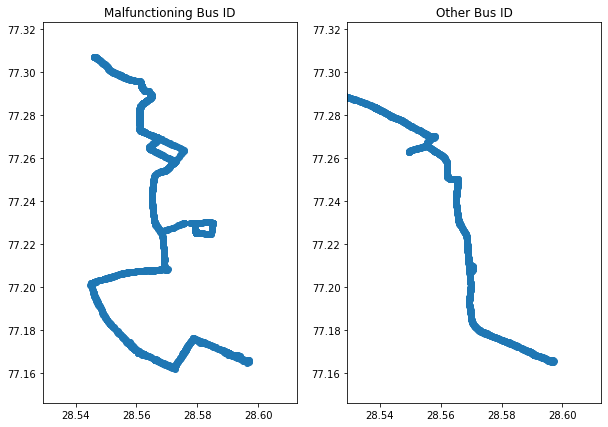

In [16]:
fig, ax = plt.subplots(1,2)
ax[0].scatter(time_sub[time_sub.deviceId == deviceIds[5]].lat, time_sub[time_sub.deviceId == deviceIds[5]].long)
xlims = ax[0].get_xlim()
ylims = ax[0].get_ylim()
ax[0].set_title("Malfunctioning Bus ID")
ax[1].scatter(time_sub[time_sub.deviceId == deviceIds[0]].lat, time_sub[time_sub.deviceId == deviceIds[0]].long)
ax[1].set_xlim(xlims)
ax[1].set_ylim(ylims)
ax[1].set_title("Other Bus ID")

In [17]:
bad_df = time_sub[time_sub.deviceId == deviceIds[5]].copy()
check_df = time_sub[time_sub.deviceId == deviceIds[0]].copy()

In [18]:
check_df["latr"] = check_df["lat"].round(4)
check_df["longr"]= check_df.long.round(4)
bad_df["latr"] = bad_df.lat.round(4)
bad_df["longr"] = bad_df.long.round(4)

In [19]:
common_entries = pd.merge(bad_df, check_df, on = ["latr", "longr"]).copy()

common_entries["difference"] = np.abs(common_entries.time_appx_x - common_entries.time_appx_y)

Text(0.5, 1.0, 'Comparison between x = Malfunctioning Device and y = Different Device at Same Level')

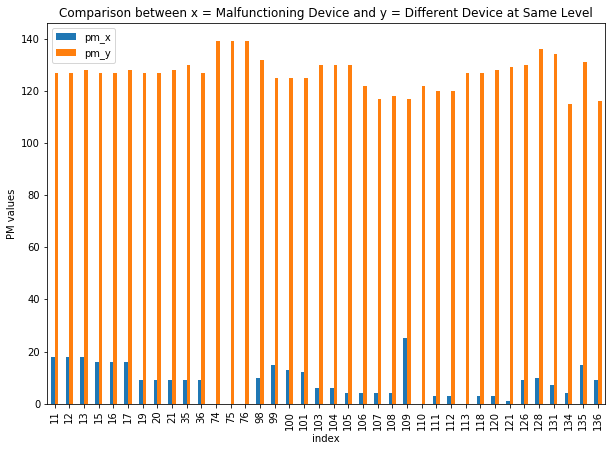

In [20]:
common_entries[common_entries.difference<30][["pm_x", "pm_y"]].plot(kind = "bar")
plt.xlabel("index")
plt.ylabel("PM values")
plt.title("Comparison between x = Malfunctioning Device and y = Different Device at Same Level")

Text(0.5, 1.0, 'Other Bus ID')

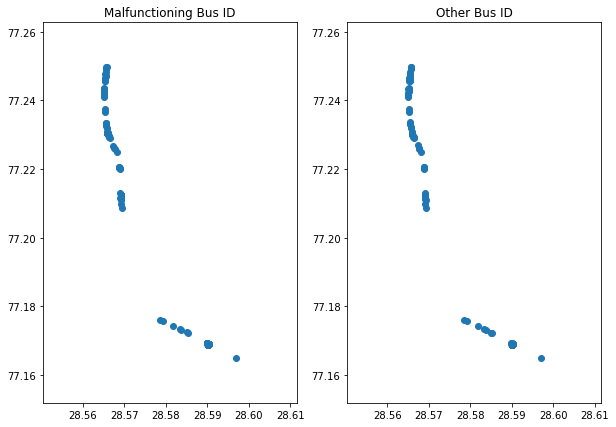

In [21]:
fig, ax = plt.subplots(1, 2)
ax[0].scatter(common_entries.lat_x, common_entries.long_x)
xlims = ax[0].get_xlim()
ylims = ax[0].get_ylim()
ax[0].set_title("Malfunctioning Bus ID")
ax[1].scatter(common_entries.lat_y, common_entries.long_y)
ax[1].set_xlim(xlims)
ax[1].set_ylim(ylims)
ax[1].set_title("Other Bus ID")

**Thus, we finally need to check once how this device is working in other datasets and then report accordingly**

Plotted below is the pm values for dataset not having malfunctioning bus data

Text(0.5, 1.0, 'pm values with time')

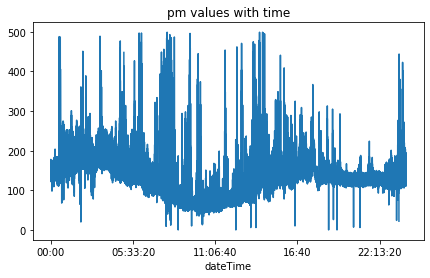

In [22]:
sub = sub[sub.deviceId != bad_id]
line_plots(sub, ["pm"])
plt.title("pm values with time")

Text(0, 0.5, 'PM')

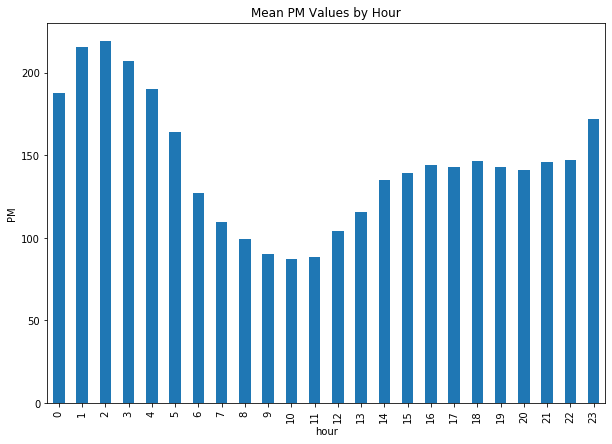

In [429]:
sub.groupby(by = "hour").mean().pm.plot(kind = "bar")
plt.title("Mean PM Values by Hour")
plt.ylabel("PM")

This looks much cleaner in terms of the low values. We will be now working with this data and excluding the low values.

**One more interesting thing that might strike us is the number of straight line spikes.** These tend to shoot straight up and then fall down really quickly. We will explore these to gain more insight into this behaviour. 

### 2. Should we have any tall short-lasting spikes (or Deep short-lasting pits) ? 

In [31]:
map_pol = {j:i for i,j in enumerate(sub.pol_class.unique())}
sub["pol_int"]= sub.pol_class.apply(lambda x: map_pol[x])
sub.sort_values(["deviceId", "dateTime"], inplace= True)

sub["pol_class_diff"] = np.abs(sub.pol_int - sub.pol_int.shift(1))
temp = sub.reset_index()
jumps = temp[temp.pol_class_diff >= 4]

Text(0, 0.5, 'PM')

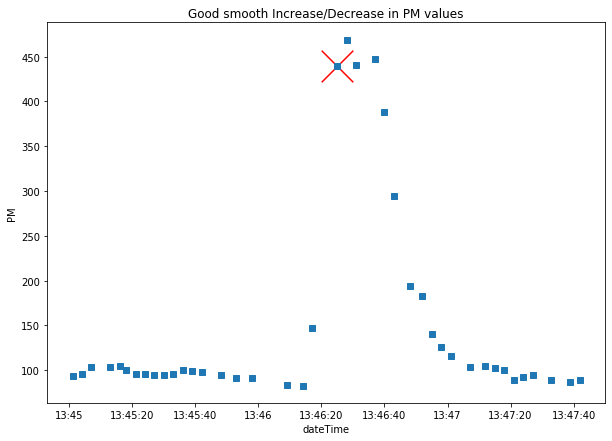

In [37]:
idx = jumps.index[2]
device = jumps.loc[idx, "deviceId"]
nbd = temp.loc[idx-20:idx+20, :]
nbd = nbd[nbd.deviceId == device]
nbd.set_index("dateTime").pm.plot(style = "s")
plt.scatter([nbd.loc[idx, "dateTime"]], [nbd.loc[idx, "pm"]], c = "red", marker = "x", s = 1000)
plt.title("Good smooth Increase/Decrease in PM values")
plt.ylabel("PM")

Text(0, 0.5, 'PM')

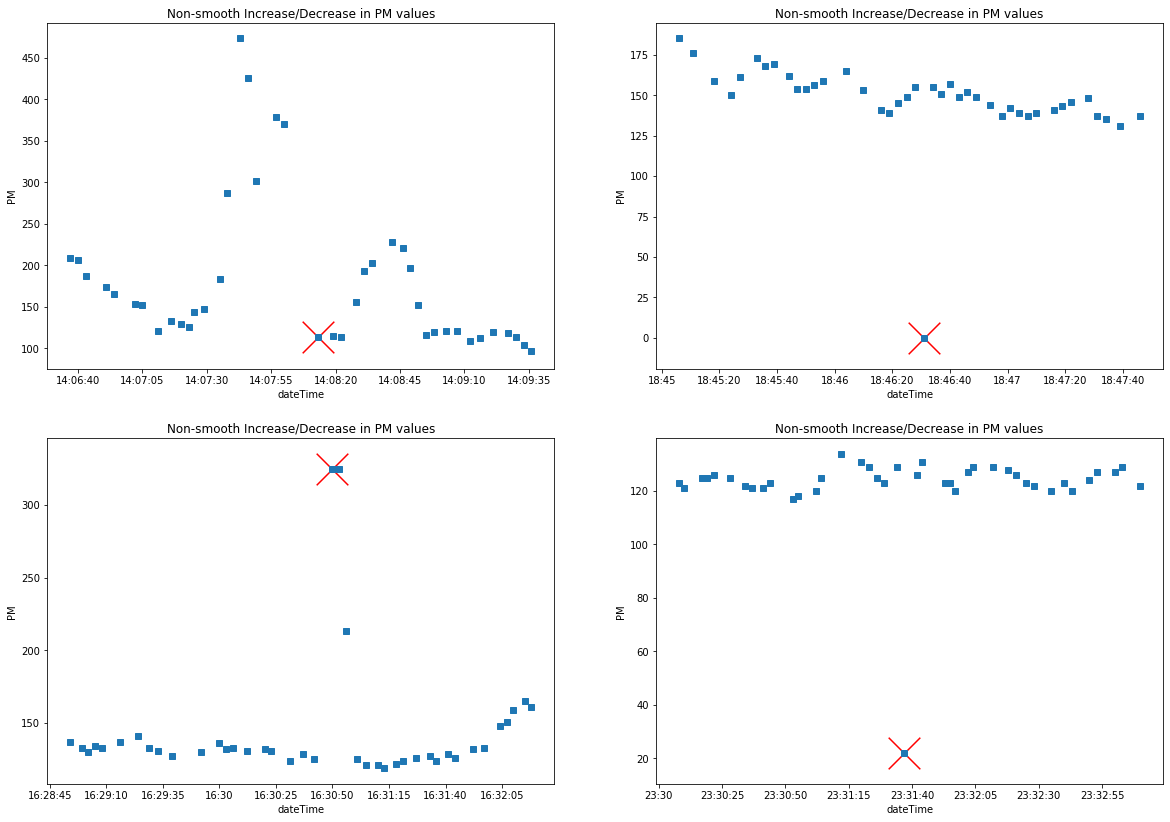

In [38]:
fig, ax = plt.subplots(2,2, figsize =(20,14))

idx = jumps.index[3]
device = jumps.loc[idx, "deviceId"]
nbd = temp.loc[idx-20:idx+20, :]
nbd = nbd[nbd.deviceId == device]
nbd.set_index("dateTime").pm.plot(style = "s", ax = ax[0][0])
ax[0][0].scatter([nbd.loc[idx, "dateTime"]], [nbd.loc[idx, "pm"]], c = "red", marker = "x", s = 1000)
ax[0][0].set_title("Non-smooth Increase/Decrease in PM values")
ax[0][0].set_ylabel("PM")

idx = jumps.index[4]
device = jumps.loc[idx, "deviceId"]
nbd = temp.loc[idx-20:idx+20, :]
nbd = nbd[nbd.deviceId == device]
nbd.set_index("dateTime").pm.plot(style = "s", ax = ax[0][1])
ax[0][1].scatter([nbd.loc[idx, "dateTime"]], [nbd.loc[idx, "pm"]], c = "red", marker = "x", s = 1000)
ax[0][1].set_title("Non-smooth Increase/Decrease in PM values")
ax[0][1].set_ylabel("PM")

idx = jumps.index[9]
device = jumps.loc[idx, "deviceId"]
nbd = temp.loc[idx-20:idx+20, :]
nbd = nbd[nbd.deviceId == device]
nbd.set_index("dateTime").pm.plot(style = "s", ax = ax[1][0])
ax[1][0].scatter([nbd.loc[idx, "dateTime"]], [nbd.loc[idx, "pm"]], c = "red", marker = "x", s = 1000)
ax[1][0].set_title("Non-smooth Increase/Decrease in PM values")
ax[1][0].set_ylabel("PM")

idx = jumps.index[20]
device = jumps.loc[idx, "deviceId"]
nbd = temp.loc[idx-20:idx+20, :]
nbd = nbd[nbd.deviceId == device]
nbd.set_index("dateTime").pm.plot(style = "s", ax = ax[1][1])
ax[1][1].scatter([nbd.loc[idx, "dateTime"]], [nbd.loc[idx, "pm"]], c = "red", marker = "x", s = 1000)
ax[1][1].set_title("Non-smooth Increase/Decrease in PM values")
ax[1][1].set_ylabel("PM")

**After seeing good and bad examples of increases and decreases in Pm values, we should try to come up with a way to deal with this automatically. How do we decide on which values to keep and which to not ? How do we decide if a jump is extreme enough or not ?**

_We can measure the change in correlation when the outlier point is removed or we could also fit a linear reg. line and see how large the error is from the expected ._

### 3. Exploring the role of other covariates

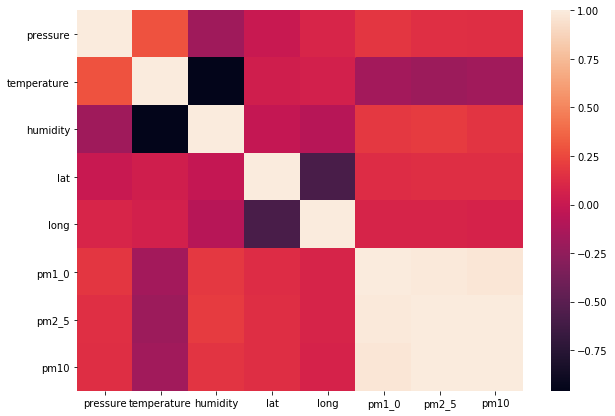

In [39]:
sns.heatmap(df[(df.lat>0) & (df.long>0) & (df.pm10<=500) & (df.pm1_0<=500) & (df.pm2_5<=500)].corr())

Text(0.5, 1.0, 'Number of Records per Pollution Class')

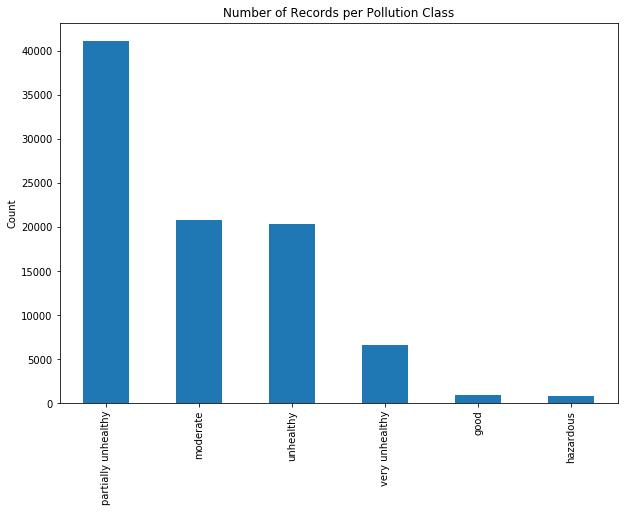

In [40]:
sub.pol_class.value_counts().plot(kind = "bar")
plt.ylabel("Count")
plt.title("Number of Records per Pollution Class")

In [41]:
pol_class_order =  ['good', 'moderate', 'partially unhealthy', 'unhealthy', 'very unhealthy', 'hazardous' ]

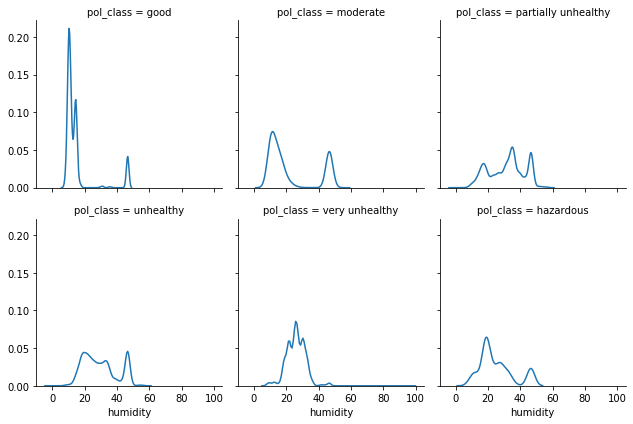

In [42]:
g = sns.FacetGrid(sub, col="pol_class", col_wrap = 3, col_order =pol_class_order)
g.map(sns.kdeplot, "humidity")

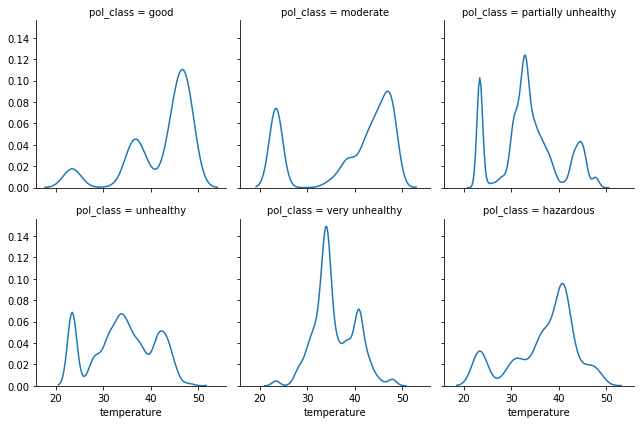

In [43]:
g = sns.FacetGrid(sub, col="pol_class", col_wrap = 3 , col_order =pol_class_order)
g.map(sns.kdeplot, "temperature")

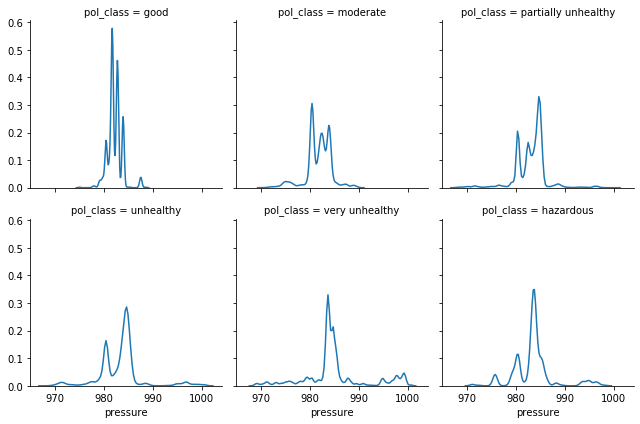

In [44]:
g = sns.FacetGrid(sub, col="pol_class", col_wrap = 3,  col_order =pol_class_order)
g.map(sns.kdeplot, "pressure")

The distributions don't really show any specific trend across the different classes. Since in real life factors are known to be related to a certain extent **we need to get more data to test this across days and divide the entire region into 4/9 squares and anlyze separately for every square.**

The scatter plots of pm with other covariates also don't give any information or show no correlation

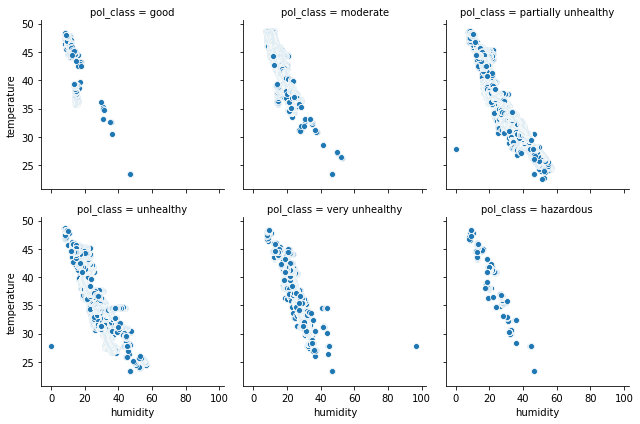

In [45]:
g = sns.FacetGrid(sub, col="pol_class", col_wrap = 3, col_order = pol_class_order)
g.map(sns.scatterplot, "humidity", "temperature")

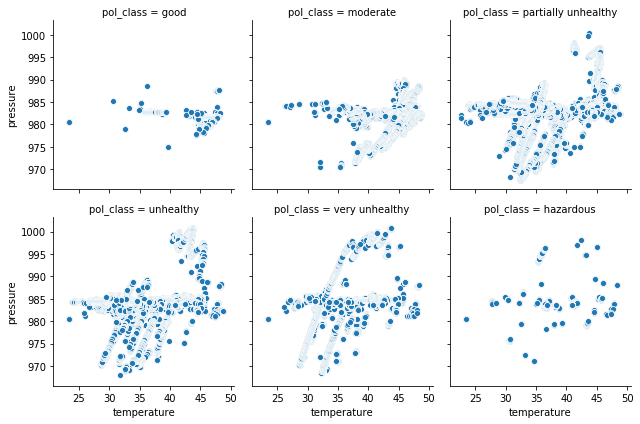

In [46]:
g = sns.FacetGrid(sub, col="pol_class", col_wrap = 3, col_order = pol_class_order)
g.map(sns.scatterplot, "temperature", "pressure")

The negative correlation in the case of temperature and humidity is pretty clear. **Can this be a case of multicollinearity?** There is some positive correlation for sure between temperature and pressure but it isn't a lot. Humidity and pressure don't show any relation.

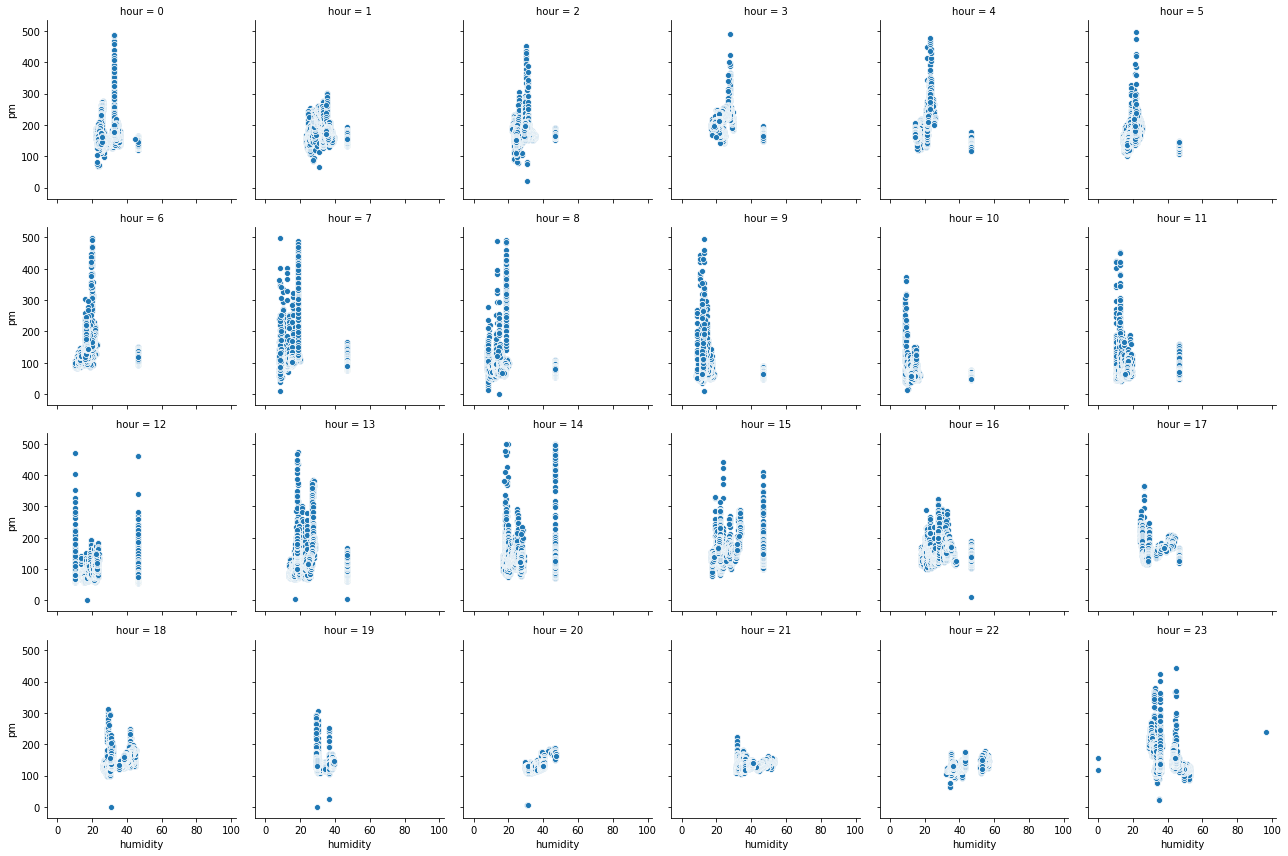

In [47]:
g = sns.FacetGrid(sub, col="hour", col_wrap = 6)
g.map(sns.scatterplot, "humidity", "pm")

We can see average humidity slightly moving with the hour. It decreases and then increases. However PM values don't change too much. For most hours we have values all across the range.

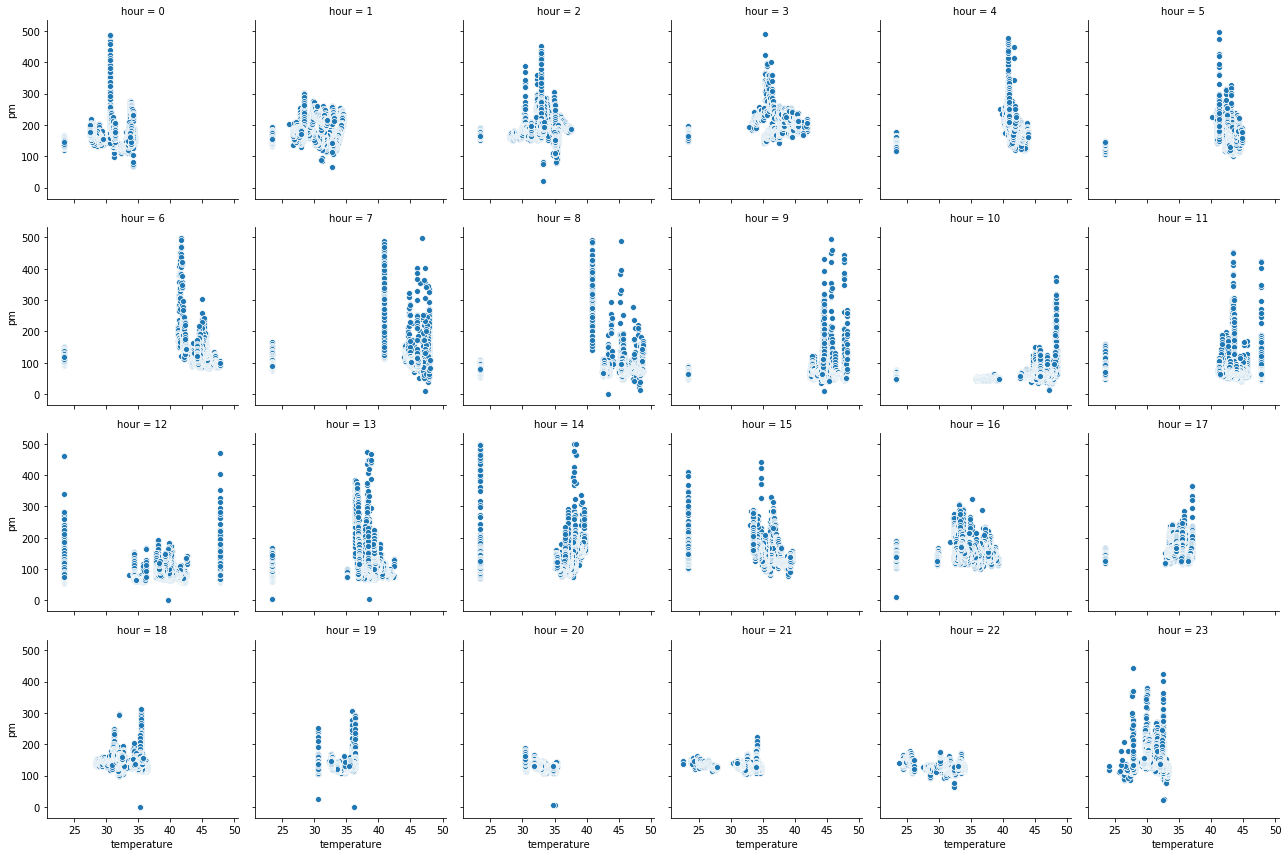

In [48]:
g = sns.FacetGrid(sub, col="hour", col_wrap = 6)
g.map(sns.scatterplot, "temperature", "pm")

The temperature moves in the opposite direction with regards to humidity as was obvious from the negative correlation. Pressure and PM doesn't give us too much information.

**I do strongly feel that when we divide the data into smaller regions, we will have a better outlook because my guess that these factoors are changing a lot with the area.**

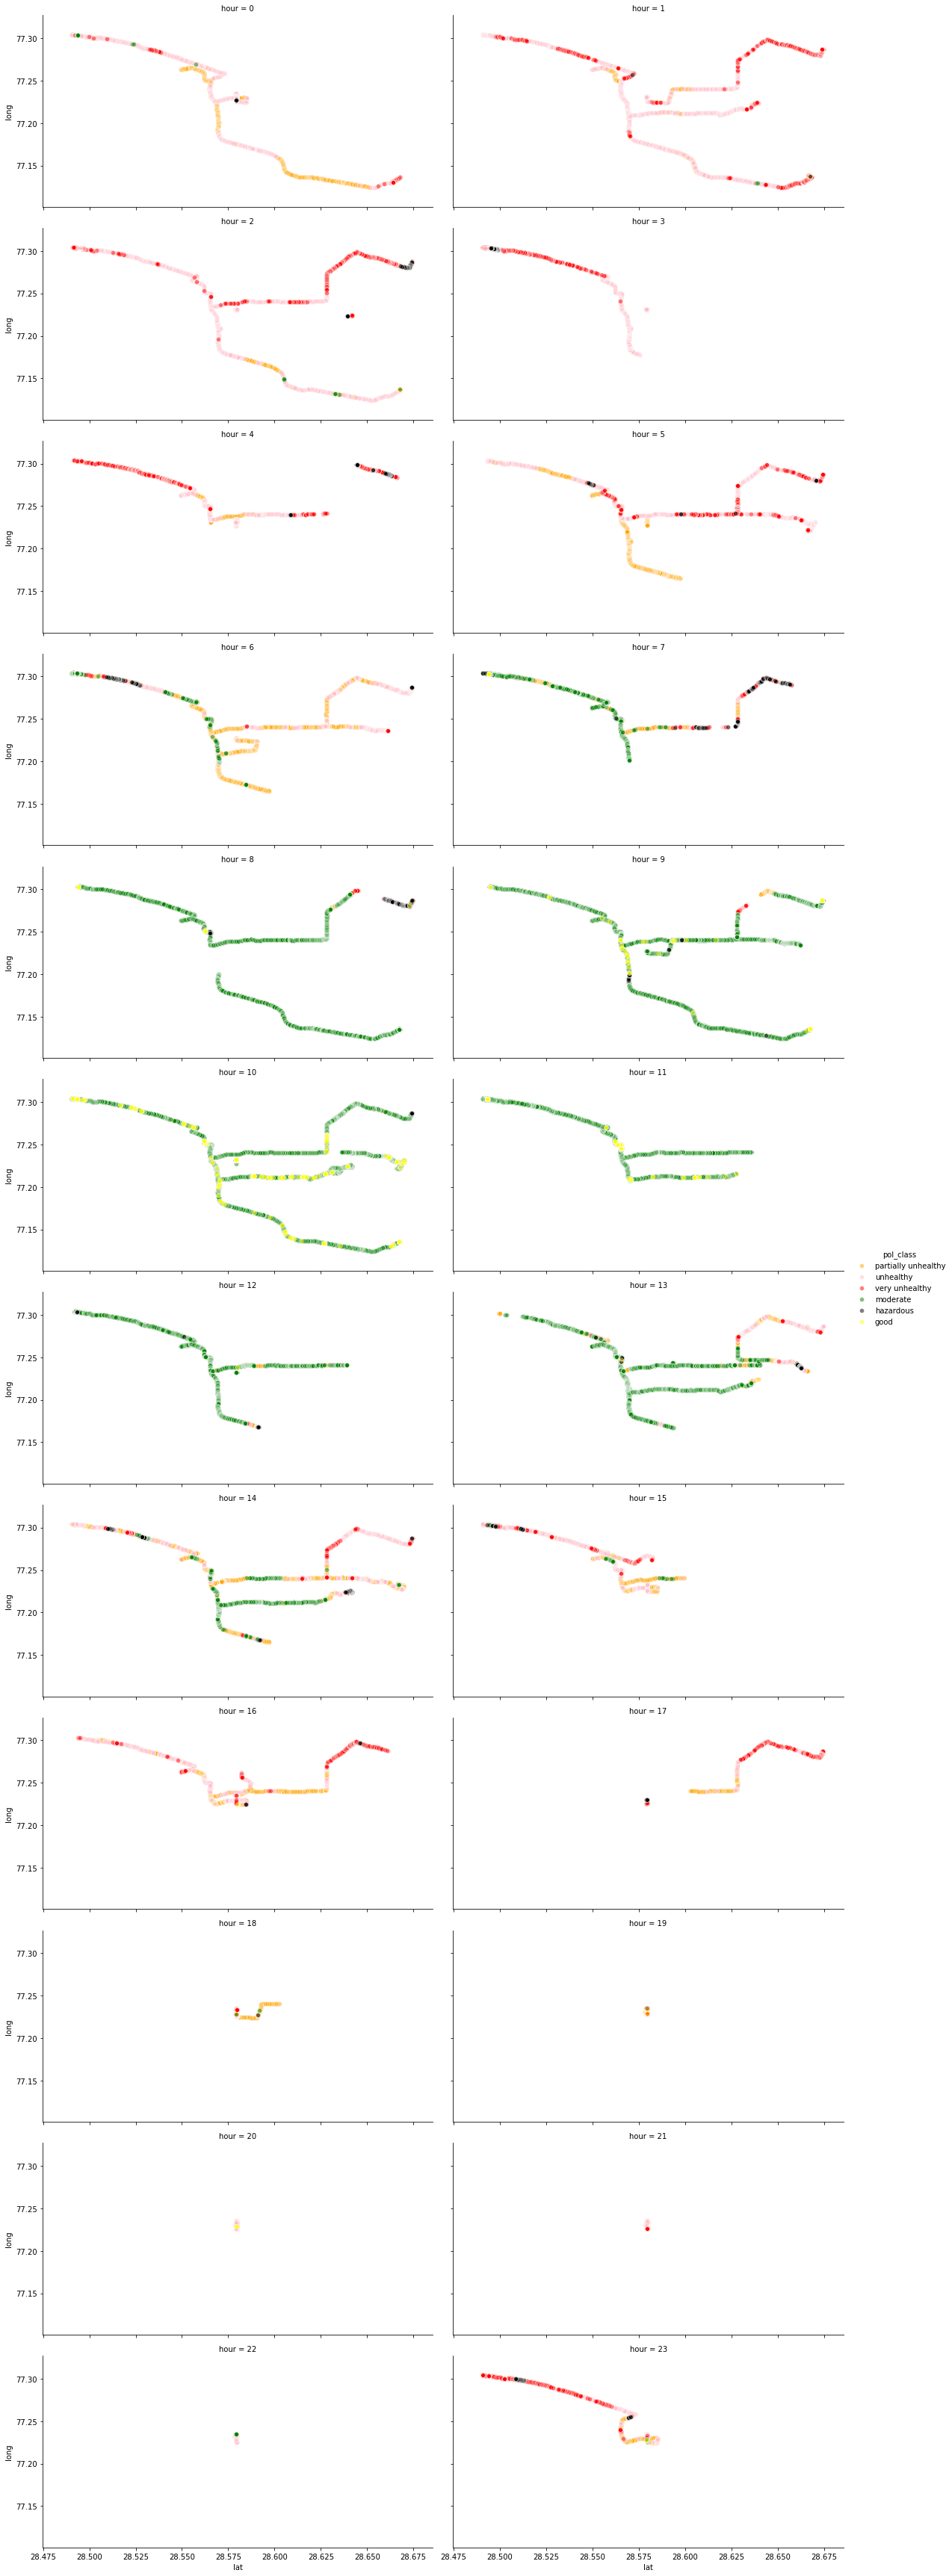

In [50]:
temp = sub[(sub.lat >0) & (sub.long >0)]
g = sns.FacetGrid(temp, col="hour", col_wrap =2, hue = "pol_class", aspect = 2, height = 4, palette = palette)
g.map(sns.scatterplot, "lat", "long", alpha = 0.5)
g.add_legend()

**Since not much can be told from this, binning should be done of lat and long values and pm values and then points should be plotted or maybe resampling might be better here.**

### 4. Way to measure natural error

In [51]:
temp = sub[(sub.lat >0) & (sub.long >0)]

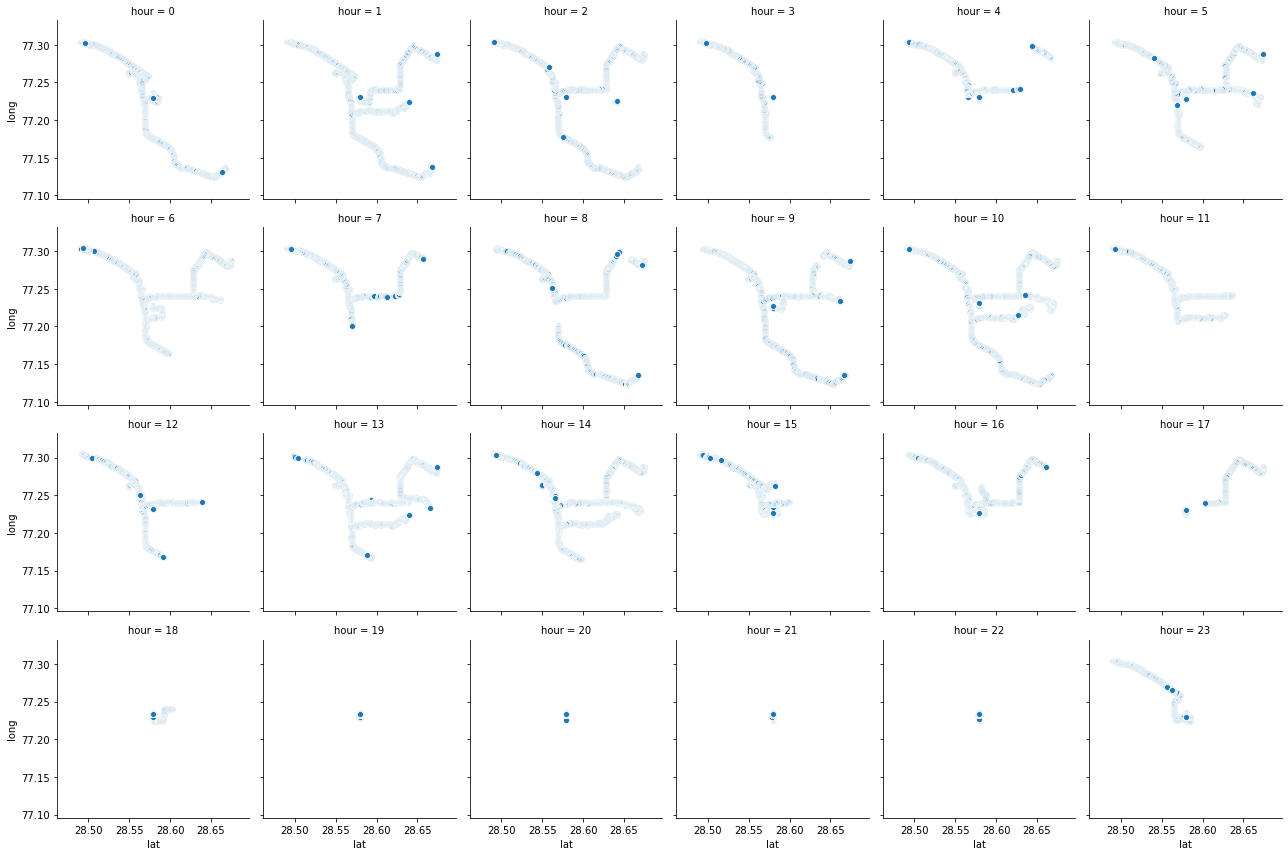

In [52]:
g = sns.FacetGrid(temp, col="hour", col_wrap = 6)
g.map(sns.scatterplot, "lat", "long")

Considering the above plot, we can easily see that there are some hours for which the buses are stationary yet we are getting readings. Using these values, we can get an estimate of:
<b>
1. Natural inherent error in one device's readings (by measuring the average deviation in a given device's readings in a mintue)
2. Natural Error across different devices (by measuring the avg deviation across the readings of differen't devices at some given timestamp)

### 5. How are the 0 PM values in our dataset distributed ?

We try to find out where all we get 0 PM values for all PM values. Do we get them at some specific points ? Is there any pattern to it ? 

In [53]:
all_zeros = df[(df.pm1_0 == 0) & (df.pm10 == 0) & (df.pm2_5 == 0)].copy()
all_zeros["hour"] = all_zeros.dateTime.apply(lambda x : x.hour)

In [54]:
all_zeros.deviceId.value_counts()

00000000d5ddcf9f    639
0000000038861c77      1
00000000078e6811      1
00000000d4bc37f2      1
Name: deviceId, dtype: int64

Text(0.5, 1.0, 'Points at which PM = 0 Recorded for ID:00000000d5ddcf9f')

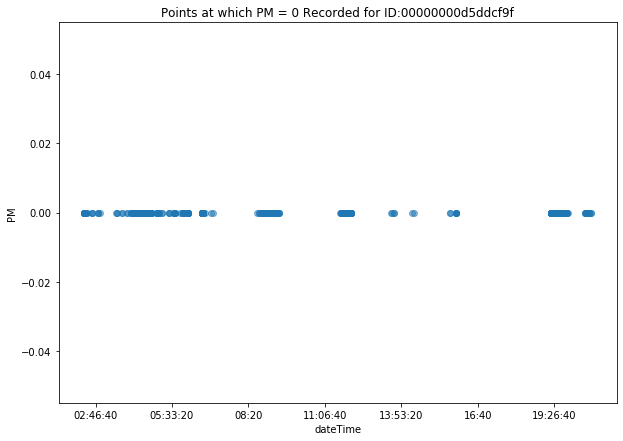

In [55]:
current_id = all_zeros.deviceId.value_counts().index[0]
all_zeros[all_zeros.deviceId == current_id].pm10.plot(style = "s", marker = "o", alpha= 0.5)
plt.ylabel("PM")
plt.title("Points at which PM = 0 Recorded for ID:" + current_id)

We end our work as this device anyway is not predicting values properly. The others seem to have not given too many 0 values so we will leave it for now.

### 6. % of outliers or "off-values" in our data (after removing data giving both lat and long 0 as done in preprocessing nb)

In [56]:
m1 = (df.lat <= 0) 
m2 = (df.long <= 0)
m3 = (df.pm1_0 <= 0) | (df.pm1_0 >= 1000)
m4 = (df.pm2_5 <= 0) | (df.pm2_5 >= 1000)
m5 = (df.pm10 <= 0) | (df.pm10 >= 1000)

print("Percent of off-values:", df[m1 | m2 | m3 | m4 | m5].shape[0]/df.shape[0] * 100,  "%")

Percent of off-values: 5.901928963207954 %


In [57]:
# for 20th Oct 2020 dataset
(49345+ df[m1 | m2 | m3 | m4 | m5].shape[0])/(df.shape[0]+49345) * 100

37.552742616033754

### 7. Movement on Delhi map

In [436]:
temp = sub[sub.hour.isin(range(0,24))].groupby(["deviceId", "time_appx"]).last()[["lat", "long"]]
temp = temp.reset_index()
temp = temp.drop(temp[(temp.lat ==0) | (temp.long ==0)].index, axis= 0)

lat_long_list = []
for i in range(temp.time_appx.min(), temp.time_appx.max(), 10):
    templ=[]
    for index, instance in temp[temp['time_appx'] == i].iterrows():
        templ.append([instance['lat'],instance['long']])
    lat_long_list.append(templ)

In [538]:
fig=Figure(width=850,height=550)
m=folium.Map(location=[28.60, 77.216721], zoom_start=11)

list_of_fs = []
list_of_lines = []
coords = []
for i, j in enumerate(temp.deviceId.unique()):
    coords.append(pd.concat([temp[temp.deviceId == j].lat, temp[temp.deviceId == j].long], axis = 1).values)
    list_of_fs.append(folium.FeatureGroup(str(i)))
    list_of_lines.append(folium.vector_layers.PolyLine(coords[i], popup='<b>Path Traversed</b>', \
                                                       tooltip=str(i), color='blue', weight=0.5, opacity = 1).add_to(list_of_fs[i]))
    list_of_fs[i].add_to(m)

HeatMapWithTime(lat_long_list,radius=15,auto_play=True,position='bottomright').add_to(m)

fig.add_child(m)
m

In [290]:
# m.save("../imgs/" +df_date + ".html")

### 8. Dividing our region to study features ( Below graphs are for data: 11th - 20th Oct )

In [55]:
clean_sub = sub.drop(sub[(sub.lat <=1) | (sub.long <=1)].index, axis = 0).copy()

In [68]:
lat_min = clean_sub.lat.min() - 0.00005
lat_max = clean_sub.lat.max() + 0.00005
long_min = clean_sub.long.min() - 0.00005
long_max = clean_sub.long.max() + 0.00005

bottomLeft = (lat_min, long_min)
bottomRight = (lat_min, long_max)
topLeft = (lat_max, long_min)
topRight = (lat_max, long_max)

cols = np.linspace(bottomLeft[1], bottomRight[1], num=3)
rows = np.linspace(bottomLeft[0], topLeft[0], num=3)
clean_sub['col'] = np.searchsorted(cols, clean_sub['long'])-1
clean_sub['row'] = np.searchsorted(rows, clean_sub['lat'])-1

In [540]:
for i in rows:
    for j in cols:
        folium.CircleMarker(location = [i, j], radius=5, tooltip="Boundary Point", color="black").add_to(m)
m

We divide the entire region into 16 squares for now and try to see if we are able to derive any relationships now.

Text(0.5, 1.0, 'Mean PM values corresponding to region')

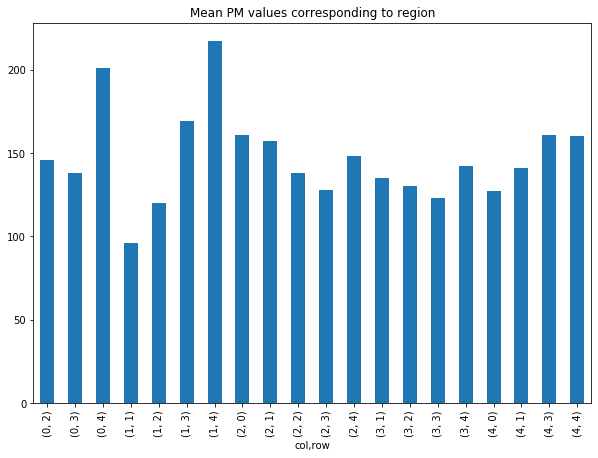

In [512]:
clean_sub.groupby(["col", "row"]).median()["pm"].plot(kind = "bar")
plt.title("Mean PM values corresponding to region")

Text(0.5, 1.0, 'STD of PM values corresponding to region')

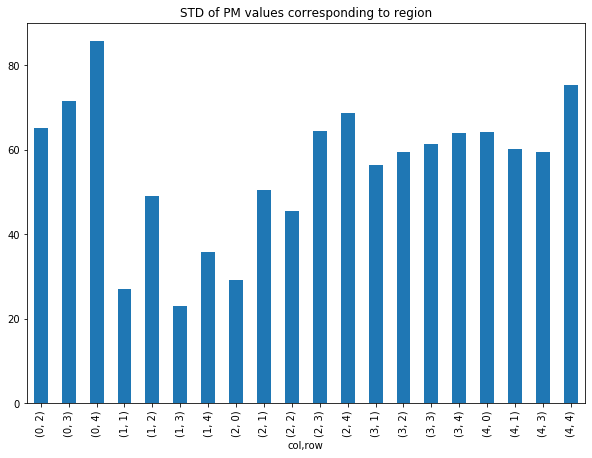

In [513]:
clean_sub.groupby(["col", "row"]).std()["pm"].plot(kind = "bar")
plt.title("STD of PM values corresponding to region")

In [525]:
subsets = []
for i in clean_sub.col.unique():
    for j in clean_sub.row.unique():
        subsets.append(clean_sub[(clean_sub.col == i) & (clean_sub.row == j)])

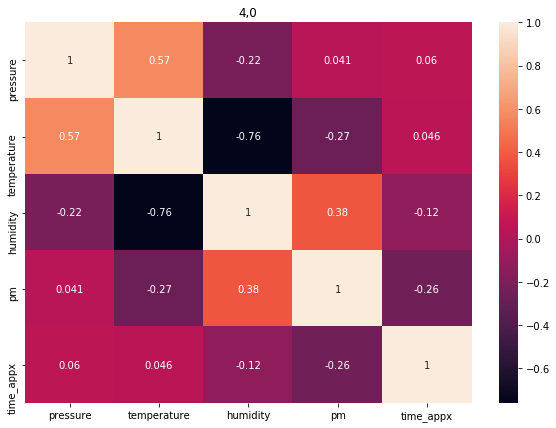

In [526]:
# by changing the below idx we can get plots for different areas
to_plot = subsets[0].copy()
to_plot.name = str(to_plot.col[0]) +","+ str(to_plot.row[0])

to_plot[(to_plot.hour == 5)].pm.plot(style = "s")
plt.title(to_plot.name)

sns.heatmap(to_plot.drop(["col", "row", "hour", "deviceId", "uid", "lat", "long", "minute"], axis = 1).corr(), annot = True)

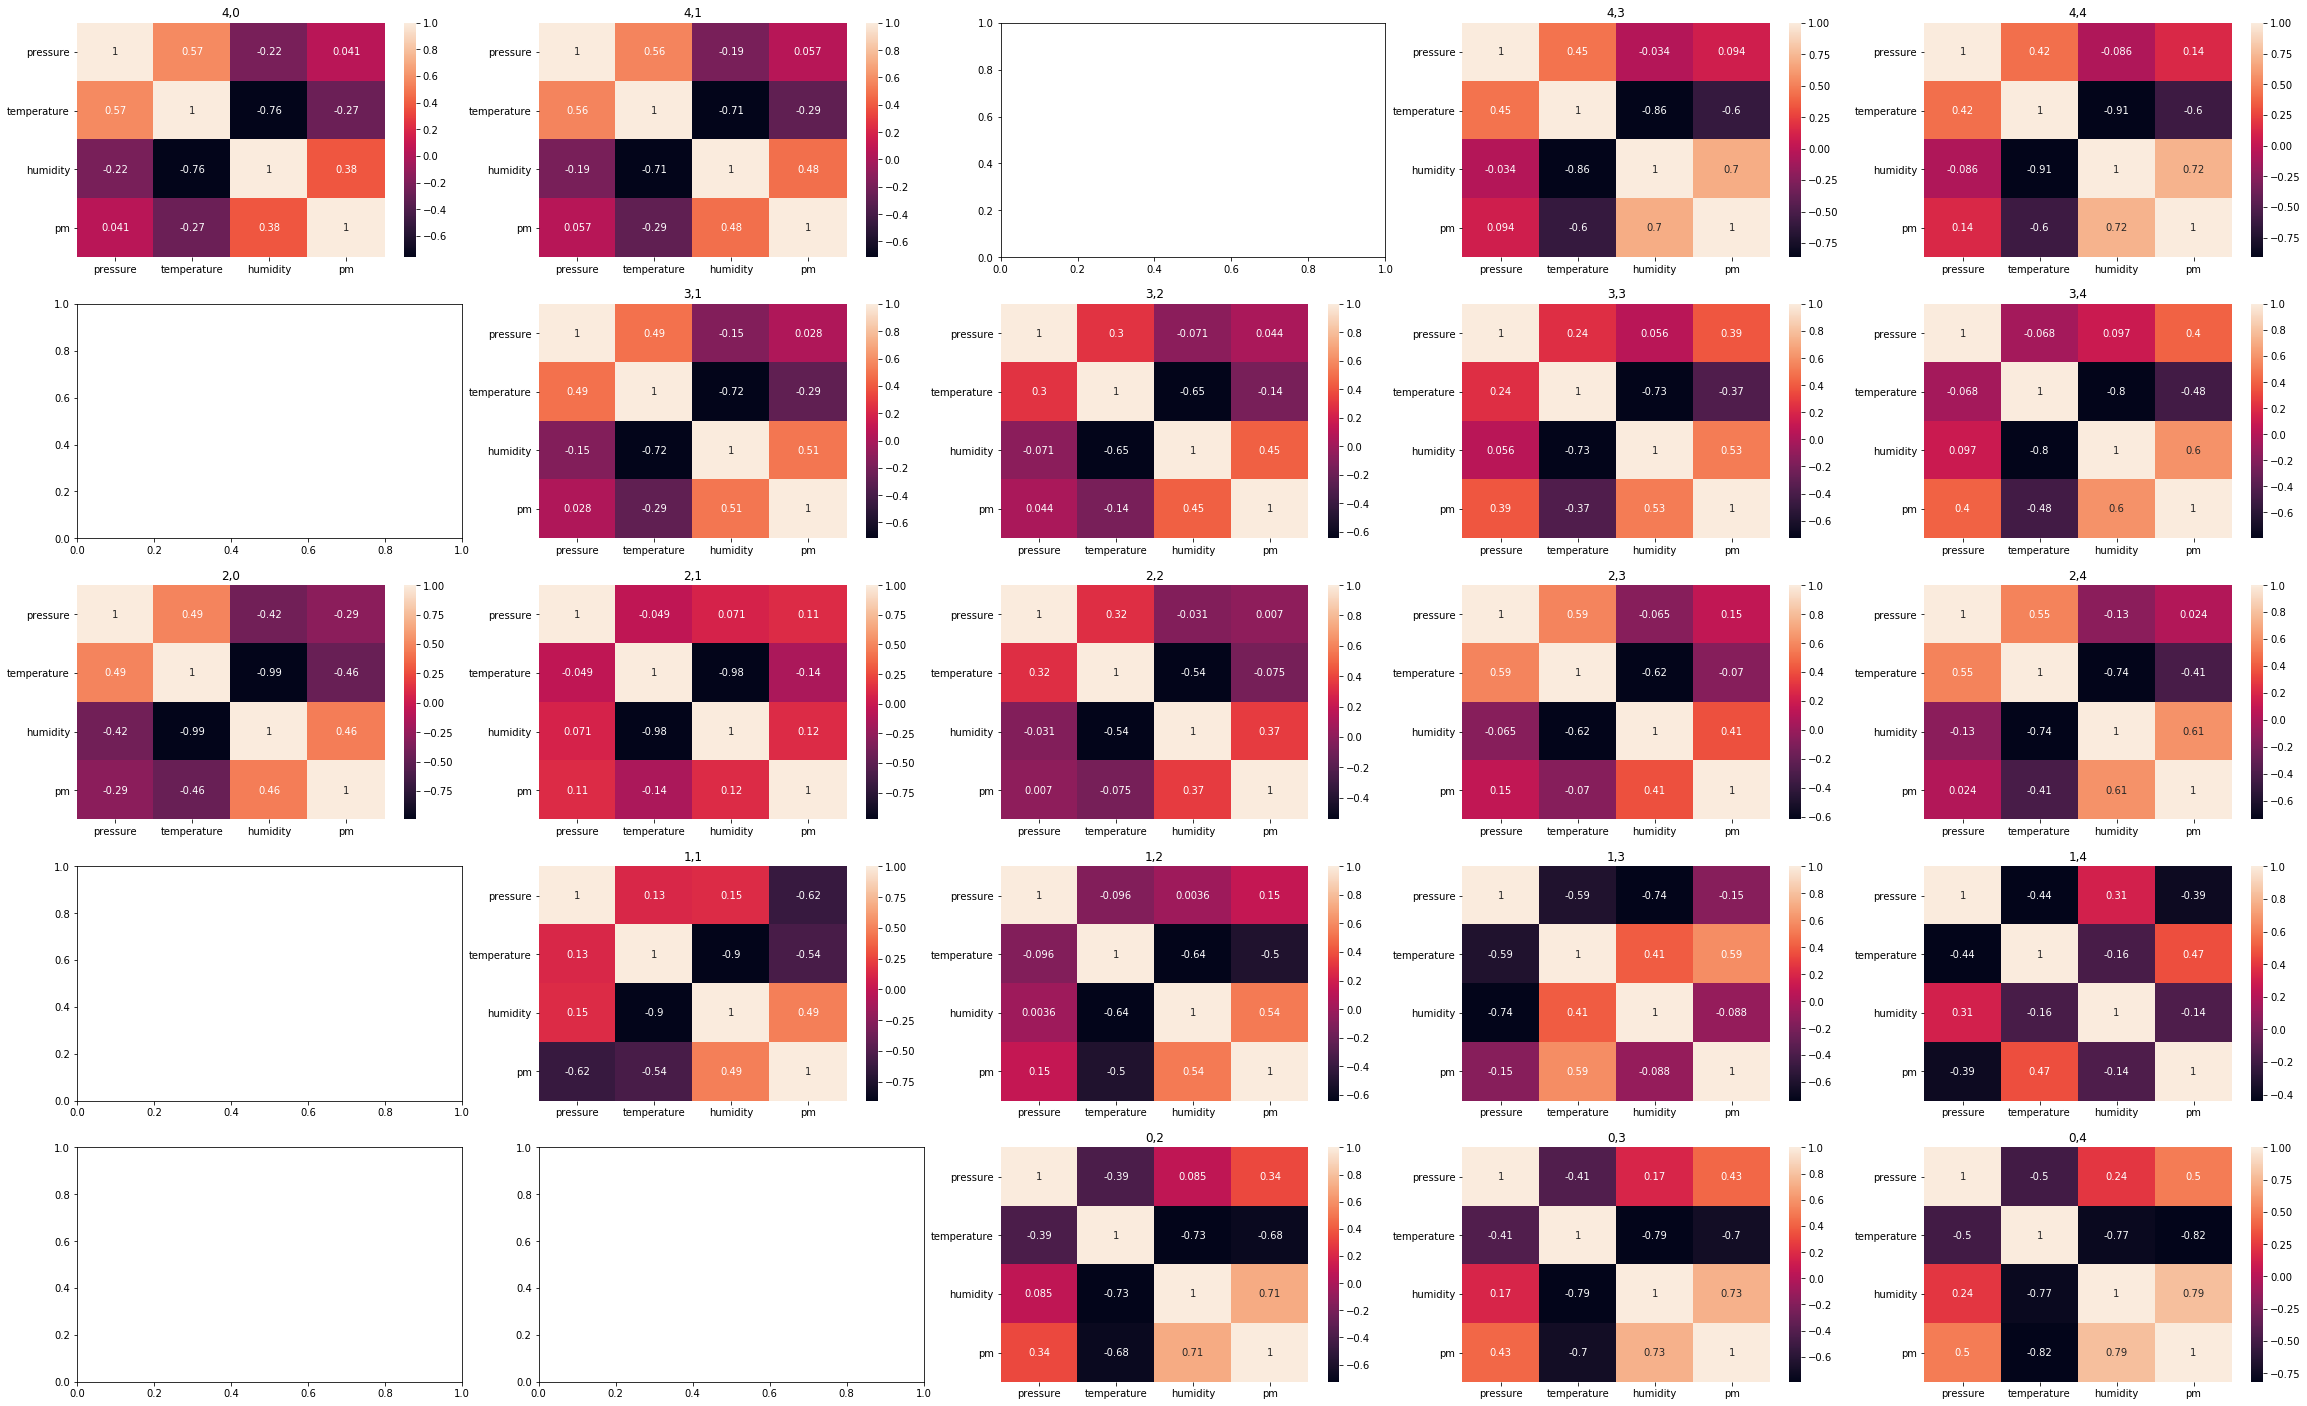

In [527]:
n_rows_cols = len(cols) - 1
fig, ax = plt.subplots(n_rows_cols, n_rows_cols, figsize = (40, 25))
for i in range(n_rows_cols):
    for j in range(n_rows_cols):
        try:
            to_plot = subsets[n_rows_cols*i+j].copy()
            to_plot.name = str(to_plot.col[0]) +","+ str(to_plot.row[0])

            sns.heatmap(to_plot.drop(["col", "row", "hour", "deviceId", "uid", "lat", "long", "minute", "time_appx"], axis = 1).corr(), annot = True, ax=ax[i][j])
            ax[i][j].set_title(to_plot.name)
        except:
            continue

So some variables are showing weak-significant correlations with other variables, especially time. The realtionships tend to change with region. Maybe if we used more data, then it would help. 

Overall the correlation becomes more accurate as we make smaller squares and it really differes from one region to the other.

C:\anaconda3\lib\site-packages\seaborn\axisgrid.py:728: UserWarning: Using the countplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


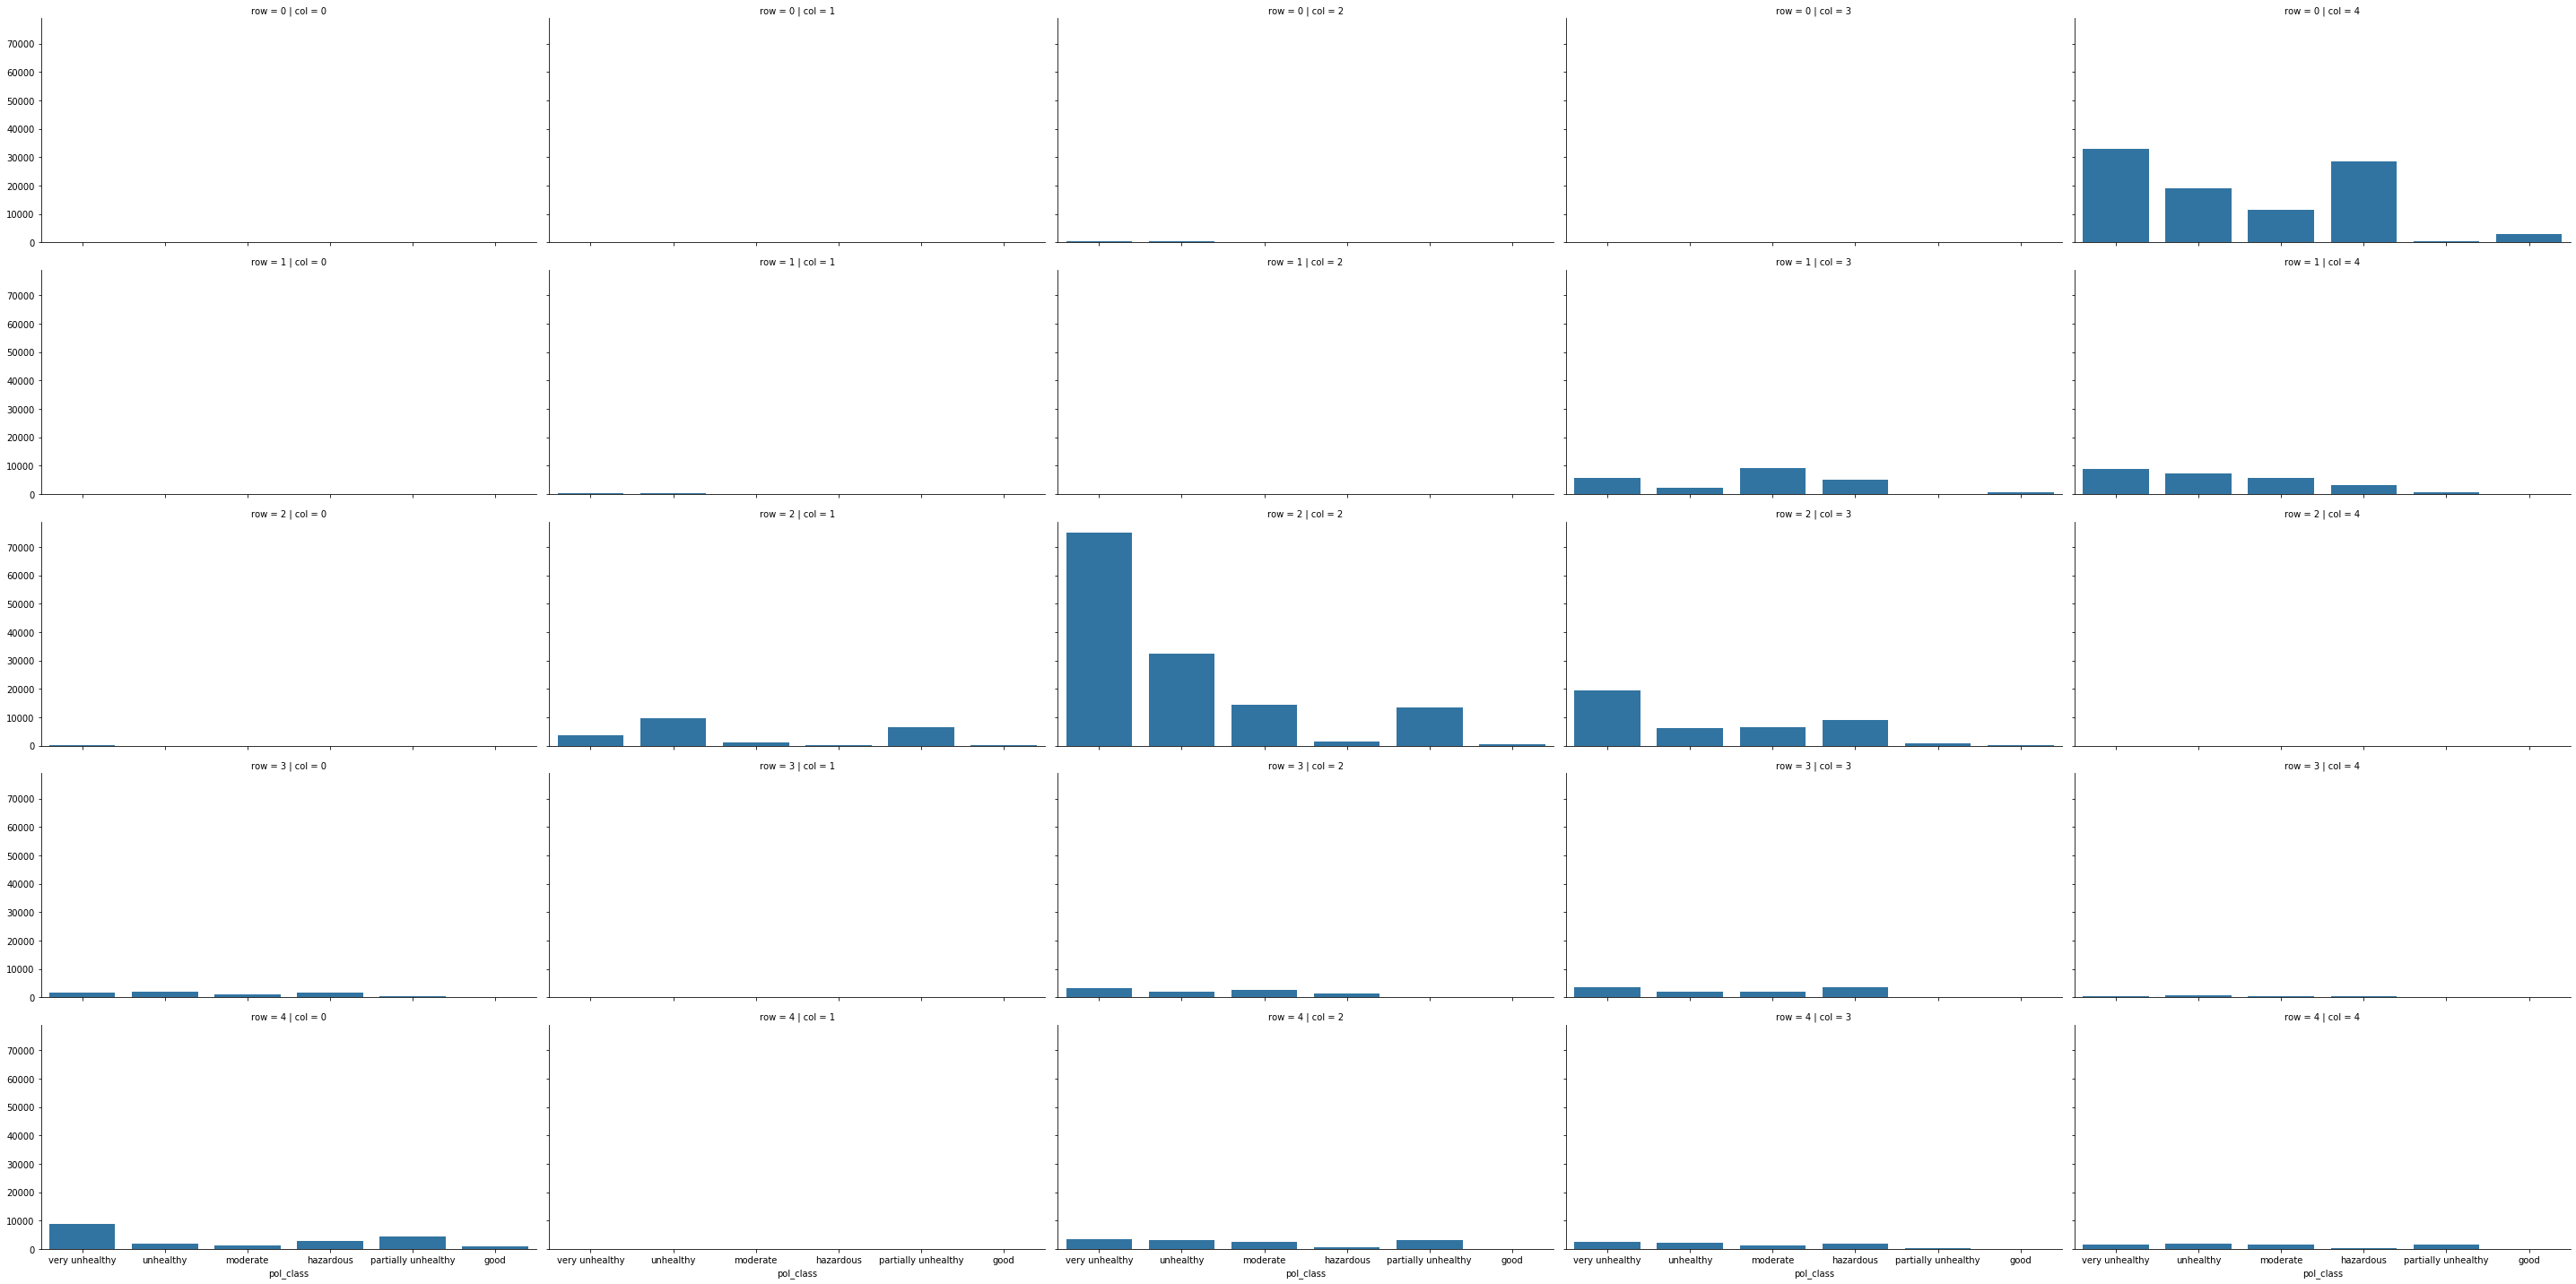

In [514]:
g = sns.FacetGrid(clean_sub, col="col",row = "row", aspect = 2, height= 4)
g.map(sns.countplot, "pol_class")

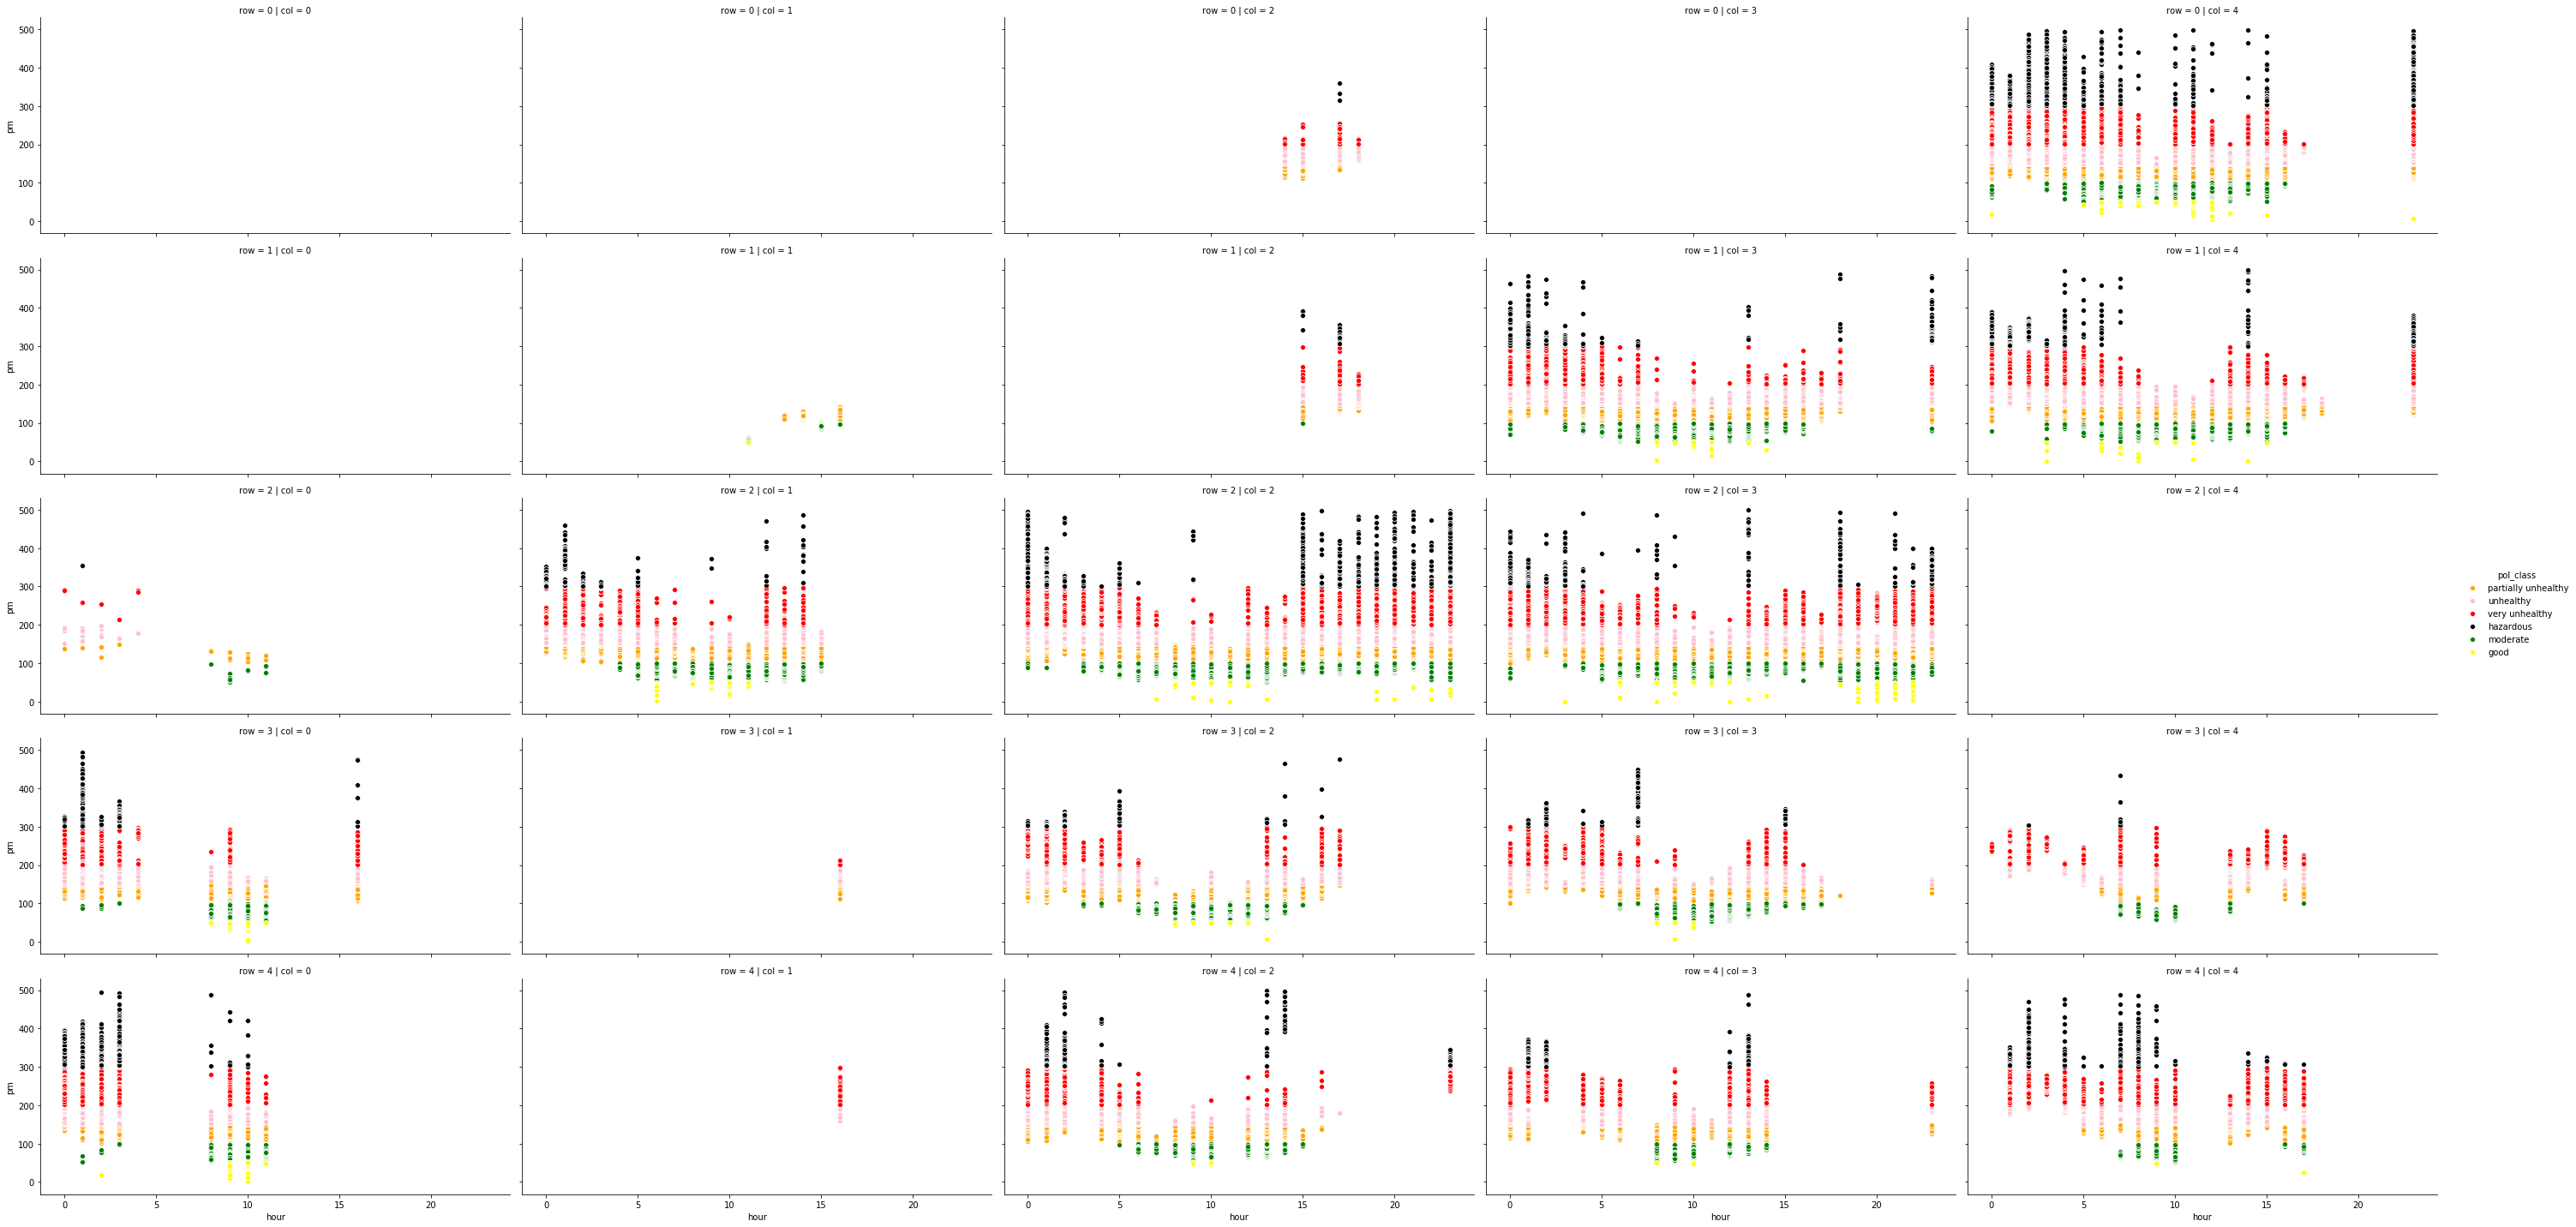

In [515]:
g = sns.FacetGrid(clean_sub, col="col", row = "row", aspect = 2, height= 4, hue = "pol_class", palette = palette)
g.map(sns.scatterplot, "hour", "pm")
g.add_legend()

I was expecting to observe particular PM classes/values for particular hours and the trend changing as the hour goes on, but there seems to be a lot of variation. There seems to be even more variation in the centre of Delhi. The "red" portion/Very unhealthy seems to be extremely constant throughout the hours and there's almost always pollution of level "very unhealthy" whenever our buses are working

The above graph also gives us an idea of the sparsity of data and the low spatio-temporal resolution we have in our case. There are places which have almost no data and this will have high uncertainty. However, the locations towards the middle have a lot of data and really accurate estimates can be made there. 

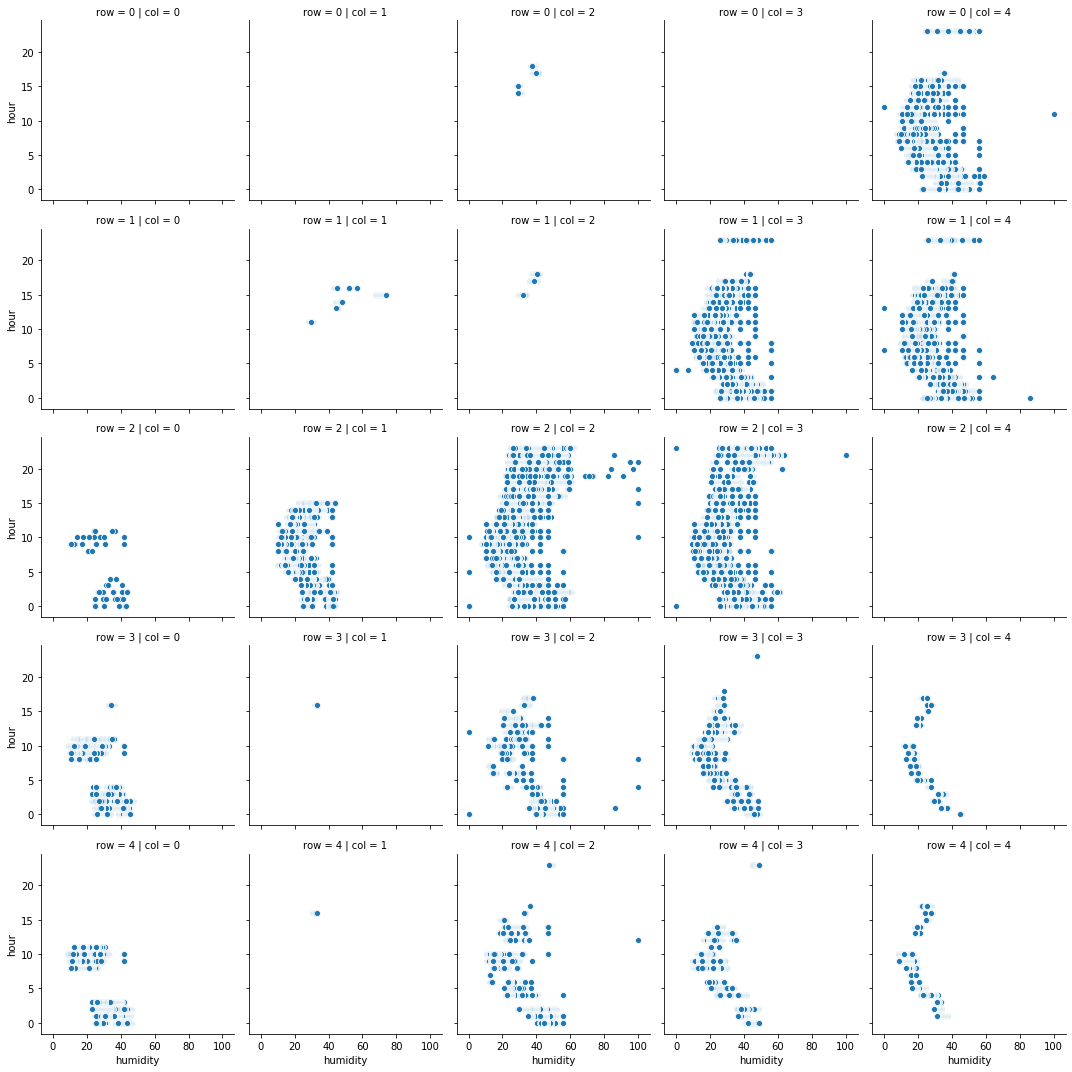

In [534]:
g = sns.FacetGrid(clean_sub, col="col", row = "row")
g.map(sns.scatterplot, "humidity", "hour")

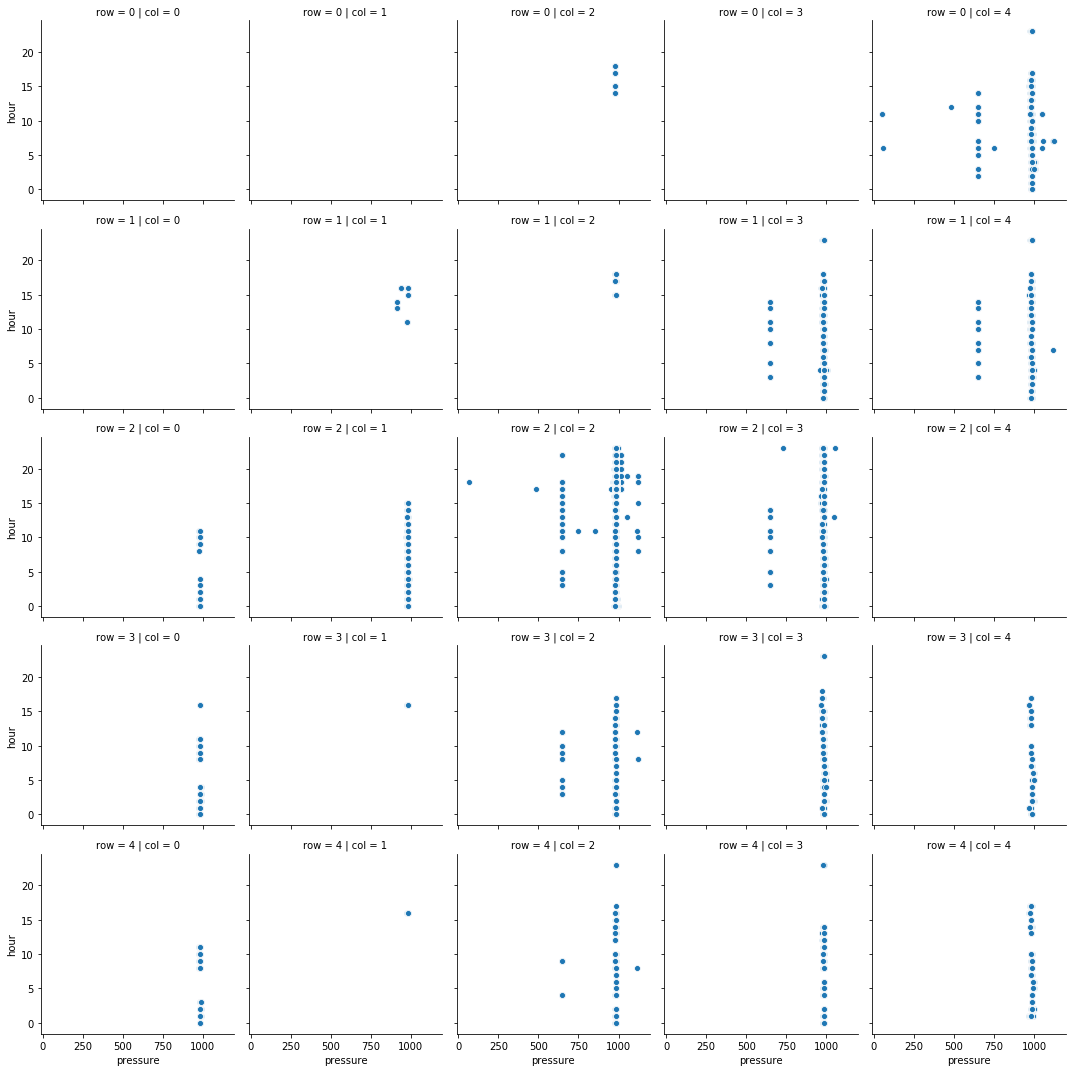

In [536]:
g = sns.FacetGrid(clean_sub, col="col", row = "row")
g.map(sns.scatterplot, "pressure", "hour")

Seeing all this data and graphs it feels like either I am missing out on something, something that should be conditioned on to explain the data (eg: traffic congestion, POI) or that I am not able to identify what to plot and how to plot or there's simply too much variation. 

### 9. Multivariate visualization

In [70]:
cols_to_choose = ['pressure', 'temperature', 'humidity', 'pm']
ss = StandardScaler()

scaled_df = ss.fit_transform(clean_sub[cols_to_choose])
scaled_df = pd.DataFrame(scaled_df, columns = cols_to_choose)
final_df = pd.concat([scaled_df, clean_sub[["col"]].reset_index(drop = True)], axis=1)
final_df.head()

pressure  temperature  humidity        pm  col
0 -0.177479    -0.266140 -0.226230  0.158079    1
1  0.318368    -0.474845  0.382480  0.895570    1
2 -0.164847    -0.266140 -0.227027  0.078350    1
3 -0.180877    -0.266140 -0.234117  0.178011    1
4 -0.177479    -0.266140 -0.235073  0.237808    1

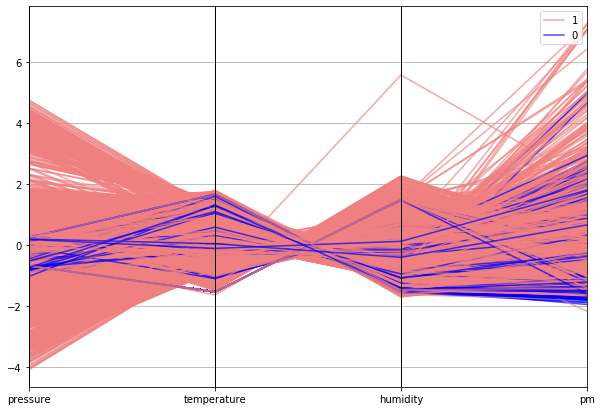

In [80]:
# plot parallel coordinates
pc = parallel_coordinates(final_df.sample(10000), 'col', color = ["lightcoral", "blue"], alpha = 0.7)

We can see that there is a difference in how concentrated the values are for col 1 and col 0. PM values and pressure values vary a lot in region 1 while in region 0 not so much. Pressure for sure the std is a lot. But we can't infer too much for PM as the values vary in both (plus if you check the actual std. you can get an idea of what is right). It's interesting to see how after pressure everything converges to temperature showing that in temp and humidity, the variation is not too much across Delhi. Thus these factors can't really be causing significant variation in the PM values. **So are we missing some factor ? Some factor that we haven't yet accounted for ?**  

This approach shows sort of reliable results (on multiple trials as sample is being taken) that when we compare different categories and the distributions of features in that category, we infer visually how spread out things are and how they vary together. However this could possibly be done probably easily be done using a boxplot or KDE to visualize different features in different categories. 